In [9]:
# !mkdir ~/.kaggle
# !touch ~/.kaggle/kaggle.json
# !chmod 600 ~/.kaggle/kaggle.json

# import json

# with open('/root/.kaggle/kaggle.json', 'w') as file:
#     json.dump(api_token, file)



In [ ]:
# !mkdir /.kaggle
# !cp kaggle.json /.kaggle
# !chmod 600 /.kaggle/kaggle.json
# !chown `whoami`: /.kaggle/kaggle.json

# !export KAGGLE_CONFIG_DIR='/.kaggle/'

In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"]="1"

from PIL import Image
# from torchinfo import summary
import torch
import os
import warnings
warnings.filterwarnings("ignore")
from typing import Tuple

from PIL import Image
import torch
import torch.nn as nn
# import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

# from datasets import load_dataset
import pandas as pd

import random

torch.cuda.empty_cache()


In [5]:
# %pip install wandb

wandb: Currently logged in as: kalexu97 (alexu97skoltech). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/jupyter/.netrc


True

In [11]:
!kaggle competitions download -c diabetic-retinopathy-detection

100%|██████████| 82.2G/82.2G [54:35<00:00, 27.0MB/s]   


In [10]:
!cp kaggle.json /home/jupyter/work/resources

In [13]:
!unzip diabetic-retinopathy-detection.zip

Archive:  diabetic-retinopathy-detection.zip
  inflating: sample.zip              
  inflating: sampleSubmission.csv.zip  
  inflating: test.zip.001            
  inflating: test.zip.002            
  inflating: test.zip.003            
  inflating: test.zip.004            
  inflating: test.zip.005            
  inflating: test.zip.006            
  inflating: test.zip.007            
  inflating: train.zip.001           
  inflating: train.zip.002           
  inflating: train.zip.003           
  inflating: train.zip.004           
  inflating: train.zip.005           
  inflating: trainLabels.csv.zip     


In [15]:
!cat train.zip.* > train.zip

In [ ]:
!unzip train.zip

In [2]:
# !unzip trainLabels.csv.zip

Archive:  trainLabels.csv.zip
  inflating: trainLabels.csv         


In [11]:
print('Number CUDA Devices:', torch.cuda.device_count())
print ('Current cuda device: ', torch.cuda.current_device(), ' **May not correspond to nvidia-smi ID above, check visibility parameter')

Number CUDA Devices: 1
Current cuda device:  0  **May not correspond to nvidia-smi ID above, check visibility parameter


In [2]:
from sklearn.model_selection import train_test_split

labelsTable = pd.read_csv('trainLabels.csv')
root_dir = 'train'
labelsTable['image_path'] = labelsTable['image'].apply(lambda x: os.path.join(root_dir, x+'.jpeg'))
labelsTable['label'] = labelsTable['level']

labelsTable = labelsTable.drop(columns=['image', 'level'], axis=1)

train_dataset, test_dataset = train_test_split(labelsTable, test_size=0.2)

In [5]:
test_dataset = pd.read_csv('test_dataset.csv')
# df_diff = pd.concat([df1,df2]).drop_duplicates(keep=False)

df = pd.concat([test_dataset, labelsTable])
df = df.reset_index(drop=True)

df_gpby = df.groupby(list(['image_path', 'label']))
idx = [x[0] for x in df_gpby.groups.values() if len(x) == 1]

train_dataset = df.reindex(idx).drop(columns=['Unnamed: 0'], axis=1)

In [3]:

# oversampling just repeating minority class items 
# enought times to be equal to major dataset in size

##############################################################################################

# max_size = train_dataset['label'].value_counts().max()
# lst = [train_dataset]
def resample(_dataset, ratio = 3):
    min_size = _dataset['label'].value_counts().min()
    lst = []
    added_unique_rows = 0
    all_n_rows = 0
    
    for class_index, group in _dataset.groupby('label'):
        # lst.append(group.sample(max_size-len(group), replace=True))
        all_n_rows += len(group)
        if class_index == 0:
            added_unique_rows += min_size*ratio
            lst.append(group.sample(min_size*ratio, replace=False))
        else:
            if len(group) > min_size*ratio:
                added_unique_rows += min_size*ratio
                lst.append(group.sample(min_size*ratio, replace=False))
            else:
                lst.append(group)
                added_unique_rows += len(group)
                lst.append(group.sample(min_size*ratio-len(group), replace=True))
        
    _dataset = pd.concat(lst)

    for class_index, group in _dataset.groupby('label'):
        print(f'{class_index}: length: {len(group)}')

    print('N_added_rows: ', added_unique_rows)
    print('N_all_rows: ', all_n_rows)
    print('Ratio of used rows: ', added_unique_rows/all_n_rows)
    return _dataset

##############################################################################################
train_dataset = resample(train_dataset, ratio = 35)
# test_dataset = resample(test_dataset, ratio = 1)


0: length: 19775
1: length: 19775
2: length: 19775
3: length: 19775
4: length: 19775
N_added_rows:  27201
N_all_rows:  28100
Ratio of used rows:  0.9680071174377224


In [4]:
from typing import Any
class Spot(object):
    def __init__(self, size, prob = 0.5):
        self.size = size
        self.prob = prob
        self.center = None
        self.radius = None
        self.zeros = torch.zeros((self.size, self.size)) #.cuda()
        self.ones = torch.ones((3, 1)) #.cuda()
        self.tensor_to_image = T.ToPILImage()

    def __call__(self, image_tensors, target = None):
        if random.random() < self.prob:

            modified_image_tensors = image_tensors.clone()
            n_spots = random.randint(5, 7)
            self.initial_mask = self.zeros.clone()

            self.dim1_offset = (image_tensors.shape[1] - self.size) // 2
            self.dim2_offset = (image_tensors.shape[2] - self.size) // 2

            for _ in range(n_spots):
                # image_tensors = self.add_random_spot(image_tensors)
                modified_image_tensors = self.add_random_spot(modified_image_tensors)
            # rerun self.tensor_to_image(torch.clamp(image_tensors, max = 255))
            return torch.clamp(modified_image_tensors, max = image_tensors.max())
        else: return image_tensors
        
    def add_random_spot(self, image_tensor):
        self.radius = random.randint(int(0.01 * self.size) + 1, int(0.05 * self.size))
        self.center = [random.randint(self.radius + 1, self.size - self.radius - 1), 
                       random.randint(self.radius + 1, self.size - self.radius - 1)]
        y, x = np.ogrid[: self.size, : self.size]
        dist_from_center = np.sqrt((x - self.center[0]) ** 2 + (y - self.center[1]) ** 2)
        circle = dist_from_center <= (self.radius // 2)

        k = 14 / 25 + (1.0 - self.radius / 25)
        beta = 0.5 + (1.5 - 0.5) * self.radius / 25
        A = k * self.ones.clone()
        d = 0.3 * self.radius / 25
        t = np.exp(-beta * d)

        spot_mask = self.zeros.clone()
        spot_mask[circle] = torch.multiply(A[0], torch.tensor(1 - t))

        self.initial_mask = self.initial_mask + spot_mask
        self.initial_mask[self.initial_mask != 0] = 1

        sigma = (5 + (2 - 0) * self.radius / 25) * 2
        rad_w = random.randint(int(sigma / 5), int(sigma / 4))
        rad_h = random.randint(int(sigma / 5), int(sigma / 4))

        if (rad_w % 2) == 0: rad_w = rad_w + 1
        if (rad_h % 2) == 0: rad_h = rad_h + 1

        spot_mask = F.gaussian_blur(torch.reshape(spot_mask, (1, self.size, self.size)), (rad_w, rad_h), sigma)
        spot_mask = torch.stack([spot_mask, spot_mask, spot_mask]) * 10
        
        image_tensor[:, self.dim1_offset : self.dim1_offset + self.size, self.dim2_offset : self.dim2_offset + self.size] += torch.reshape(spot_mask, (3, self.size, self.size))
        return image_tensor




class Halo(object):
    def __init__(self, size, prob = 0.5, intensity_range = (0.8, 1.2)):
        self.size = size
        self.prob = prob
        self.center = None
        self.radius = None
        self.intensity_range = intensity_range
        self.tensor_to_image = T.ToPILImage()

    def __call__(self, image_tensors, target = None):
        # max_val = image_tensors
        if random.random() < self.prob:
            # print('Yes')
            modified_image_tensors = image_tensors.clone()
            # print(f'Min value: {torch.amin(modified_image_tensors)}')
            # print(f'Max value: {torch.amax(modified_image_tensors)}')
            n_halos = random.randint(5, 7)

            self.dim1_offset = (image_tensors.shape[1] - self.size) // 2
            self.dim2_offset = (image_tensors.shape[2] - self.size) // 2
            
            for _ in range(n_halos):
                modified_image_tensors = self.add_random_halo(modified_image_tensors)
                # modified_image_tensors = self.add_random_halo(modified_image_tensors)
            # return torch.clamp(modified_image_tensors, max = image_tensors.max())
            return modified_image_tensors
        # torch.clamp(modified_image_tensors, max = image_tensors.max())
            # return torch.clamp(modified_image_tensors, min = torch.amin(image_tensors), max = torch.amax(image_tensors))
        else: return image_tensors

    def add_random_halo(self, image_tensor):
        self.radius = random.randint(int(0.01 * self.size), int(0.05 * self.size))
        self.center = [random.randint(self.radius + 1, self.size - self.radius - 1),
                        random.randint(self.radius + 1, self.size - self.radius - 1)]
        
        y, x = torch.meshgrid(torch.arange(self.size), torch.arange(self.size))
        dist_from_center = torch.sqrt(((x - self.center[0]) ** 2 + (y - self.center[1]) ** 2))
        normalized_dist = dist_from_center / self.radius
        
        halo_intensity = torch.clamp(self.intensity_range[0] + (self.intensity_range[1] - self.intensity_range[0]) * (1 - normalized_dist), min = 0, max = 1)
        halo_mask = dist_from_center <= self.radius // 2
        halo_effect = halo_intensity * (self.radius - dist_from_center) / self.radius
        halo_effect = np.clip(halo_effect, 0, 1)
        halo_effect = np.expand_dims(halo_effect, axis = 0)
        halo_effect = np.repeat(halo_effect, image_tensor.shape[0], axis = 0)
        image_tensor[:, halo_mask] = image_tensor[:, halo_mask] * (1 - halo_effect[:, halo_mask]) + halo_effect[:, halo_mask]

        return image_tensor
    


class Hole(object):
    def __init__(self, size, prob = 0.5):
        self.size = size
        self.prob = prob
        self.center = None
        self.radius = None
        self.tensor_to_image = T.ToPILImage()

    def __call__(self, image_tensors, target = None):
        if random.random() < self.prob:
            # print('Yes')
            modified_image_tensors = image_tensors.clone()
            # print(f'Min value: {torch.amin(modified_image_tensors)}')
            # print(f'Max value: {torch.amax(modified_image_tensors)}')
            n_halos = random.randint(5, 7)

            self.dim1_offset = (image_tensors.shape[1] - self.size) // 2
            self.dim2_offset = (image_tensors.shape[2] - self.size) // 2
            
            for _ in range(n_halos):
                image_tensors = self.add_random_hole(image_tensors)
                # modified_image_tensors = self.add_random_hole(modified_image_tensors)
            return torch.clamp(image_tensors, min = torch.amin(image_tensors), max = torch.amax(image_tensors))
            # return torch.clamp(modified_image_tensors, min = torch.amin(image_tensors), max = torch.amax(image_tensors))
        else: return image_tensors

    def add_random_hole(self, image_tensor):
        self.radius = random.randint(int(0.01 * self.size), int(0.05 * self.size))
        self.center = [random.randint(self.radius + 1, self.size - self.radius - 1),
                        random.randint(self.radius + 1, self.size - self.radius - 1)]
        
        y, x = torch.meshgrid(torch.arange(self.size), torch.arange(self.size))
        dist_from_center = torch.sqrt(((x - self.center[0]) ** 2 + (y - self.center[1]) ** 2))
        
        hole_mask = dist_from_center <= self.radius // 2
        image_tensor[:, hole_mask] = 0

        return image_tensor

class Blur(object):
    def __init__(self, sigma=None, prob = 0.5):
        self.level_range = [0.1, 1]
        self.sigma = sigma
        self.prob = prob

    def __get_parameter(self):
        return np.random.uniform(self.level_range[0], self.level_range[1])

    def __call__(self, image, target=None):
        if random.random() < self.prob:
           
            rad_w = random.randint(10, 50)
            if (rad_w % 2) == 0: rad_w = rad_w + 1
            rad_h = rad_w
            image = F.gaussian_blur(image, (rad_w,rad_h))

        return image
    
from PIL import ImageEnhance

def RandomSharpen(image, alpha = 0.2):
    sharpener = ImageEnhance.Sharpness(image)
    factor = 0.5  
    image = sharpener.enhance(1.0 + alpha * factor)
    return image

In [4]:
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
from datasets import Dataset
from transformers import ViTImageProcessor
from transformers import AutoImageProcessor

# model_name_or_path = 'google/vit-base-patch16-224-in21k'
# model_name_or_path = "microsoft/swinv2-tiny-patch4-window8-256"
# model_name_or_path = "microsoft/swin-base-patch4-window12-384"
model_name_or_path = "./saved_models/swin384" #'faster_vit_4_21k_384'
# model_name_or_path = "faster_vit_4_21k_384"
 
# processor = ViTImageProcessor.from_pretrained(model_name_or_path)
image_processor = AutoImageProcessor.from_pretrained(model_name_or_path)
image_processor.size['height'] = 512
image_processor.size['width'] = 512
        
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)

print(size)

recrop_transfrom  = T.CenterCrop(2000)
randomcrop_transform = T.RandomCrop(2000, padding_mode='symmetric', pad_if_needed=True)

_transforms_train = T.Compose([
    T.RandomHorizontalFlip(p = 0.5),
    T.RandomVerticalFlip(p = 0.5),
    T.RandomCrop(2000, padding_mode='symmetric', pad_if_needed=True),
    # Spot()
    # Sharpness(),
    # Blur()
])

_transforms_test = T.Compose([
    T.CenterCrop(2000),
])

def load_image(path_image, label, mode):
    # load image
    image = Image.open(path_image)

    if mode == 'train':
        image = _transforms_train(image)

        return image
    else:
        image = _transforms_test(image)
        return image
        

def func_transform(examples):
    
    # loaded_images = [load_image(path, lb, 'train').convert("RGB") for path, lb in zip(examples['image_path'], examples['label'])]
    # _transforms(img.convert("RGB"))
    inputs = image_processor([load_image(path, lb, 'train')
                                for path, lb in zip(examples['image_path'], examples['label'])], return_tensors='pt')
    inputs['label'] = examples['label']
    return inputs

    ###############################
    
    # examples["pixel_values"] = [load_image(path, lb, 'train') 
    #                             for path, lb in zip(examples['image_path'], examples['label'])]
    # del examples["image_path"]
    # return examples
    
    

def func_transform_test(examples):
    
    # loaded_images = [load_image(path, lb, 'test').convert("RGB") for path, lb in zip(examples['image_path'], examples['label'])]
    inputs = image_processor([load_image(path, lb, 'test')
                                for path, lb in zip(examples['image_path'], examples['label'])], return_tensors='pt')
    inputs['label'] = examples['label']
    return inputs

    ########################################
    # examples["pixel_values"] = [load_image(path, lb, 'test')
    #                             for path, lb in zip(examples['image_path'], examples['label'])]
    # del examples["image_path"]
    # return examples
    
    

train_ds = Dataset.from_pandas(train_dataset, preserve_index=False)
test_ds = Dataset.from_pandas(test_dataset, preserve_index=False)

prepared_ds_train = train_ds.with_transform(func_transform)
prepared_ds_test = test_ds.with_transform(func_transform_test)

prepared_ds_train = prepared_ds_train.shuffle(seed=42)
prepared_ds_test = prepared_ds_test.shuffle(seed=42)

2024-05-25 12:28:35.297138: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-25 12:28:36.804878: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(512, 512)


In [5]:
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
from datasets import Dataset
from transformers import ViTImageProcessor
from transformers import AutoImageProcessor

###################################################HSV

size = 512

_transforms_train = T.Compose([
    T.CenterCrop(2000), 
    T.Resize((560, 560), interpolation=T.InterpolationMode.BICUBIC),
    T.RandomHorizontalFlip(p = 0.5),
    T.RandomVerticalFlip(p = 0.5),
    T.RandomCrop(size, padding_mode='symmetric', pad_if_needed=True),
    # T.Lambda(lambda image: image.convert('HSV')),
    # RandomSharpen,
    # Blur(),
    # T.TrivialAugmentWide(),
    T.ToTensor(),
    # T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    T.Normalize(mean=[0.5], std=[0.5]),
    # T.Resize((size, size), interpolation=T.InterpolationMode.BICUBIC),
    # Spot(size=size),
    # Halo(size=size),
    # Hole(size=size)
])

_transforms_test = T.Compose([
    T.CenterCrop(2000),
    # T.Lambda(lambda image: image.convert('HSV')),
    T.ToTensor(),
    T.Normalize(mean=[0.5], std=[0.5]),
    # T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    T.Resize((size, size), interpolation=T.InterpolationMode.BICUBIC),
])

###################################################

def load_image(path_image, label, mode):
    # load image
    image = Image.open(path_image)

    if mode == 'train':
        image = _transforms_train(image)

        return image
    else:
        image = _transforms_test(image)
        return image
        

def func_transform(examples):
    
    # loaded_images = [load_image(path, lb, 'train').convert("RGB") for path, lb in zip(examples['image_path'], examples['label'])]
    # _transforms(img.convert("RGB"))
    # inputs = image_processor([load_image(path, lb, 'train')
    #                             for path, lb in zip(examples['image_path'], examples['label'])], return_tensors='pt')
    # inputs['pixel_values'] = [post_transforms_train(img_tensor) for img_tensor in inputs['pixel_values']]
    
    # inputs['label'] = examples['label']
    # return inputs

    ###############################
    
    examples["pixel_values"] = [load_image(path, lb, 'train') 
                                for path, lb in zip(examples['image_path'], examples['label'])]
    del examples["image_path"]
    return examples
    
    

def func_transform_test(examples):
    
    # loaded_images = [load_image(path, lb, 'test').convert("RGB") for path, lb in zip(examples['image_path'], examples['label'])]
    
    # inputs = image_processor([load_image(path, lb, 'test')
    #                             for path, lb in zip(examples['image_path'], examples['label'])], return_tensors='pt')
    # inputs['label'] = examples['label']
    # return inputs

    ########################################
    examples["pixel_values"] = [load_image(path, lb, 'test')
                                for path, lb in zip(examples['image_path'], examples['label'])]
    del examples["image_path"]
    return examples
    
    

train_ds = Dataset.from_pandas(train_dataset, preserve_index=False)
test_ds = Dataset.from_pandas(test_dataset, preserve_index=False)

prepared_ds_train = train_ds.with_transform(func_transform)
prepared_ds_test = test_ds.with_transform(func_transform_test)

prepared_ds_train = prepared_ds_train.shuffle(seed=42)
prepared_ds_test = prepared_ds_test.shuffle(seed=42)



2024-05-25 10:40:28.747757: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-25 10:40:30.253082: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [10]:
# %pip install fsspec==2024.2.0
# %pip install s3fs==2024.2.0
# !python3 -m pip install --upgrade pip

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.9 MB/s eta 0:00:00


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [5]:
print("rows in train_dataset: ", len(prepared_ds_train))
print("rows in test_dataset: ", len(prepared_ds_test))

# labels = prepared_ds_train.features["label"].names()
labels = [0, 1, 2, 3, 4]
label2id, id2label = dict(), dict()

for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label
    
print("ID2label: ", id2label)

rows in train_dataset:  98875
rows in test_dataset:  7026
ID2label:  {0: 0, 1: 1, 2: 2, 3: 3, 4: 4}


In [6]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

In [12]:
# %pip install evaluate

In [7]:
from sklearn.metrics import cohen_kappa_score, confusion_matrix
from sklearn.metrics import f1_score #, kappa
# from sklearn import metrics

import evaluate

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions_proba, labels = eval_pred

    # print(predictions)
    predictions = np.argmax(predictions_proba, axis=1)
    # print(predictions)
    # print(labels)
    result_accuracy = accuracy.compute(predictions=predictions, references=labels)

    result = {
             'accuracy': np.mean([result_accuracy['accuracy']]),
             'kappa': np.mean([cohen_kappa_score(labels, predictions, weights = "quadratic")]),
             # 'quadratic_kappa': np.mean([kappa(labels, predictions, weights = "quadratic")]),
             'f1': np.mean([f1_score(labels, predictions, average='weighted')]),
             # 'roc_auc': np.mean([roc_auc_score(labels, predictions_proba, multi_class='ovr')])
             }

    cm = confusion_matrix(labels, predictions)
    print(cm)

    # print(cohen_kappa_score(labels, predictions))
    # print(result)

    return result


In [14]:
# %pip install fastervit
# %pip install timm==0.9.6
# %pip install tensorboardX==2.6.2.2
# %pip install onnx==1.14.1
# %pip install onnx_graphsurgeon==0.3.27
# %pip install onnxruntime==1.15.1
# %pip install polygraphy==0.47.1
# %pip install -r src/requirements.txt

In [18]:


# config = AutoConfig.from_pretrained("./saved_models/swin384_spot_p05_rt20_3")

In [13]:
!ls saved_models

effNetb5_originpreprocessor_rt15      swin384_originpreprocessor_rt15.zip
effNetb5_originpreprocessor_rt15.zip  swin384_pTrspot_shrpblr_2
effNetb5_rt20_onlsh_lbsmth05	      swin384_rcp1500_rt20_onlblur
effNetb5_rt20_onlsh_lbsmth05.zip      swin384_rcp1500_rt20_onlshr
fastervit_4_21k_384_w24.pth.tar       swin384_shrp_rt20
fastervit_4_21k_512_w32.pth.tar       swin384_spot_p05_rt20_3
swin384_originpreprocessor_rt15


In [8]:
from transformers import PreTrainedModel
from fastervit import create_model
from transformers import AutoConfig

# model = create_model('faster_vit_0_224', num_classes=5)
# model = create_model('faster_vit_4_21k_384', num_classes=5)


class FasterViT(PreTrainedModel):

    def __init__(self, config):
        super().__init__(config)
        self.model = create_model('faster_vit_4_21k_512', #'faster_vit_4_21k_224', #'faster_vit_4_21k_512',                  #'faster_vit_4_21k_384',
                                  num_classes=5,
                                  pretrained=True,
                                  # model_path="saved_models/fastervit_4_21k_384_w24.pth.tar",
                                  # model_path="saved_models/fastervit_4_21k_512_w32.pth.tar",
                                 )
        self.loss_f = torch.nn.CrossEntropyLoss()

    def forward(self, pixel_values, labels=None):
        # print(tensor)
        logits = self.model(pixel_values)
        # print(logits)
        # print(labels)
        if labels is not None:
            loss = self.loss_f(logits, labels)
            return {"loss": loss, "logits": logits}
        return {"logits": logits}

temp_config = AutoConfig.from_pretrained("./saved_models/swin384")
model = FasterViT(temp_config)

100%|██████████| 3.97G/3.97G [01:47<00:00, 39.5MB/s] 


The model and loaded state dict do not match exactly

size mismatch for head.weight: copying a param with shape torch.Size([1000, 1568]) from checkpoint, the shape in current model is torch.Size([5, 1568]).
size mismatch for head.bias: copying a param with shape torch.Size([1000]) from checkpoint, the shape in current model is torch.Size([5]).


In [12]:
# from transformers import Swinv2ForImageClassification
# from transformers import SwinForImageClassification

# model = SwinForImageClassification.from_pretrained(
#     model_name_or_path,
#     num_labels=len(labels),
#     id2label=id2label,
#     label2id=label2id,
#     ignore_mismatched_sizes=True,
# )

In [18]:
# %pip install accelerate -U

In [9]:
from transformers import TrainingArguments

r_name = "FasterViT512_tr35_randCrop"

training_args = TrainingArguments(
    output_dir="./fastVit-base",
    evaluation_strategy="steps",
    logging_steps=50,

    save_steps=50,
    eval_steps=50,
    save_total_limit=2,
    
    report_to="wandb",  # enable logging to W&B
    run_name=r_name,  # name of the W&B run (optional)
    
    remove_unused_columns=False,
    dataloader_num_workers = 8,
    lr_scheduler_type = 'cosine', # 'constant', # _with_warmup', #'cosine', #
    
    learning_rate=12e-6,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=4,
    num_train_epochs=5,
    warmup_ratio=0.02,
    
    metric_for_best_model="kappa", 
    greater_is_better = True,
    load_best_model_at_end=True,
    
    push_to_hub=False
)

In [10]:
sample_ids = np.random.choice(len(prepared_ds_test), size=1000, replace=False)
inv_sample_ids = np.setdiff1d(np.arange(len(prepared_ds_test)), sample_ids)
val_ds = prepared_ds_test.select(sample_ids)
test_ds = prepared_ds_test.select(inv_sample_ids)

In [14]:
# with open('test_indeces.npy', 'wb') as f:
    
#     np.save(f, sample_ids)
#     np.save(f, inv_sample_ids)

with open('test_indeces.npy', 'rb') as f:
    sample_ids = np.load(f)
    inv_sample_ids = np.load(f)

val_ds = prepared_ds_test.select(sample_ids)
test_ds = prepared_ds_test.select(inv_sample_ids)

In [11]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds_train,
    # eval_dataset=prepared_ds_test,
    eval_dataset=val_ds,
    # tokenizer=image_processor,
)

In [12]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

wandb: Currently logged in as: kalexu97 (alexu97skoltech). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.17.0
wandb: Run data is saved locally in /home/jupyter/work/resources/Diabetic-retinopathy-classification/wandb/run-20240525_123334-sh1q26vm
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run FasterViT512_tr35_randCrop
wandb: ⭐️ View project at https://wandb.ai/alexu97skoltech/huggingface
wandb: 🚀 View run at https://wandb.ai/alexu97skoltech/huggingface/runs/sh1q26vm
  0%|          | 50/30895 [02:07<21:21:45,  2.49s/it]

{'loss': 1.7403, 'grad_norm': 195.77615356445312, 'learning_rate': 9.70873786407767e-07, 'epoch': 0.01}



100%|█████████▉| 249/250 [00:54<00:00,  4.61it/s]
                                                     
100%|██████████| 250/250 [00:54<00:00,  3.92it/s]
                                                 

[[187 122  70  83 268]
 [ 17  12   4  15  26]
 [ 39  15  12  20  67]
 [  7   3   3   1  13]
 [  5   1   3   0   7]]
{'eval_loss': 1.6693683862686157, 'eval_accuracy': 0.219, 'eval_kappa': 0.021561406457725307, 'eval_f1': 0.30092330337464956, 'eval_runtime': 56.6934, 'eval_samples_per_second': 17.639, 'eval_steps_per_second': 4.41, 'epoch': 0.01}


  0%|          | 100/30895 [05:40<21:17:13,  2.49s/it]

{'loss': 1.7064, 'grad_norm': 58.80569839477539, 'learning_rate': 1.941747572815534e-06, 'epoch': 0.02}



100%|█████████▉| 249/250 [00:54<00:00,  4.62it/s]
                                                      
100%|██████████| 250/250 [00:54<00:00,  3.93it/s]
                                                 

[[231 213  66 134  86]
 [ 23  23   4  16   8]
 [ 48  30  13  34  28]
 [  9   5   2   5   6]
 [  6   1   3   0   6]]
{'eval_loss': 1.5718920230865479, 'eval_accuracy': 0.278, 'eval_kappa': 0.052031449900011184, 'eval_f1': 0.3509947181949489, 'eval_runtime': 56.5206, 'eval_samples_per_second': 17.693, 'eval_steps_per_second': 4.423, 'epoch': 0.02}


  0%|          | 150/30895 [09:13<21:13:34,  2.49s/it] 

{'loss': 1.6469, 'grad_norm': 401.574462890625, 'learning_rate': 2.912621359223301e-06, 'epoch': 0.02}



100%|█████████▉| 249/250 [00:54<00:00,  4.62it/s]
                                                      
100%|██████████| 250/250 [00:54<00:00,  3.93it/s]
                                                 

[[139 323 138  56  74]
 [ 20  28   7   9  10]
 [ 25  51  31  24  22]
 [  4   5   6   7   5]
 [  2   0   6   0   8]]
{'eval_loss': 1.5983803272247314, 'eval_accuracy': 0.213, 'eval_kappa': 0.11057588920906647, 'eval_f1': 0.2619899899833091, 'eval_runtime': 57.0173, 'eval_samples_per_second': 17.539, 'eval_steps_per_second': 4.385, 'epoch': 0.02}


  1%|          | 200/30895 [12:45<21:11:25,  2.49s/it] 

{'loss': 1.5747, 'grad_norm': 288.2354431152344, 'learning_rate': 3.883495145631068e-06, 'epoch': 0.03}



100%|█████████▉| 249/250 [00:54<00:00,  4.63it/s]
                                                      
100%|██████████| 250/250 [00:54<00:00,  3.91it/s]
                                                 

[[ 35 573  51  41  30]
 [  7  58   3   3   3]
 [  7  97  12  19  18]
 [  1  10   4  11   1]
 [  0   5   2   3   6]]
{'eval_loss': 1.6411815881729126, 'eval_accuracy': 0.122, 'eval_kappa': 0.1729696218226906, 'eval_f1': 0.10064568551509799, 'eval_runtime': 56.4841, 'eval_samples_per_second': 17.704, 'eval_steps_per_second': 4.426, 'epoch': 0.03}


  1%|          | 250/30895 [16:18<21:12:54,  2.49s/it] 

{'loss': 1.524, 'grad_norm': 227.65431213378906, 'learning_rate': 4.854368932038836e-06, 'epoch': 0.04}



100%|█████████▉| 249/250 [00:54<00:00,  4.61it/s]
                                                      
100%|██████████| 250/250 [00:54<00:00,  3.95it/s]
                                                 

[[ 51 573  62  13  31]
 [  6  59   6   1   2]
 [  9 102  17  11  14]
 [  1  10  10   4   2]
 [  0   4   3   2   7]]
{'eval_loss': 1.539217472076416, 'eval_accuracy': 0.138, 'eval_kappa': 0.180128219857993, 'eval_f1': 0.1316085647338826, 'eval_runtime': 56.6525, 'eval_samples_per_second': 17.651, 'eval_steps_per_second': 4.413, 'epoch': 0.04}


  1%|          | 300/30895 [19:51<21:12:45,  2.50s/it] 

{'loss': 1.4691, 'grad_norm': 600.7972412109375, 'learning_rate': 5.825242718446602e-06, 'epoch': 0.05}



100%|█████████▉| 249/250 [00:54<00:00,  4.62it/s]
                                                      
100%|██████████| 250/250 [00:54<00:00,  3.95it/s]
                                                 

[[121 508  45  21  35]
 [ 14  51   4   4   1]
 [ 14  89  14  21  15]
 [  1   7   1  15   3]
 [  1   3   1   3   8]]
{'eval_loss': 1.4410077333450317, 'eval_accuracy': 0.209, 'eval_kappa': 0.24546523345649984, 'eval_f1': 0.24266813567848122, 'eval_runtime': 56.589, 'eval_samples_per_second': 17.671, 'eval_steps_per_second': 4.418, 'epoch': 0.05}


  1%|          | 350/30895 [23:25<21:08:22,  2.49s/it] 

{'loss': 1.4777, 'grad_norm': 101.90887451171875, 'learning_rate': 6.79611650485437e-06, 'epoch': 0.06}



100%|█████████▉| 249/250 [00:54<00:00,  4.61it/s]
                                                      
100%|██████████| 250/250 [00:54<00:00,  3.93it/s]
                                                 

[[205 424  15  43  43]
 [ 20  46   1   5   2]
 [ 23  67   2  39  22]
 [  1   5   1  16   4]
 [  0   1   0   6   9]]
{'eval_loss': 1.3447184562683105, 'eval_accuracy': 0.278, 'eval_kappa': 0.2963683527885862, 'eval_f1': 0.32966523894181143, 'eval_runtime': 56.6438, 'eval_samples_per_second': 17.654, 'eval_steps_per_second': 4.414, 'epoch': 0.06}


  1%|▏         | 400/30895 [26:57<21:04:02,  2.49s/it] 

{'loss': 1.4323, 'grad_norm': 152.7241973876953, 'learning_rate': 7.766990291262136e-06, 'epoch': 0.06}



100%|█████████▉| 249/250 [00:54<00:00,  4.62it/s]
                                                      
100%|██████████| 250/250 [00:54<00:00,  3.95it/s]
                                                 

[[148 477  42  20  43]
 [ 18  49   3   2   2]
 [ 17  66  20  30  20]
 [  0   5   0  16   6]
 [  0   0   0   6  10]]
{'eval_loss': 1.355579137802124, 'eval_accuracy': 0.243, 'eval_kappa': 0.31167638292687494, 'eval_f1': 0.28740488627471716, 'eval_runtime': 56.5133, 'eval_samples_per_second': 17.695, 'eval_steps_per_second': 4.424, 'epoch': 0.06}


  1%|▏         | 450/30895 [30:29<21:02:32,  2.49s/it] 

{'loss': 1.4015, 'grad_norm': 52.26415252685547, 'learning_rate': 8.737864077669904e-06, 'epoch': 0.07}



100%|█████████▉| 249/250 [00:54<00:00,  4.60it/s]
                                                      
  1%|▏         | 450/30895 [31:25<21:02:32,  2.49s/it]


[[208 432  16  31  43]
 [ 28  41   1   4   0]
 [ 15  79   8  36  15]
 [  2   3   1  19   2]
 [  0   0   0   7   9]]
{'eval_loss': 1.3220583200454712, 'eval_accuracy': 0.285, 'eval_kappa': 0.311130858092184, 'eval_f1': 0.3439173066218017, 'eval_runtime': 56.6587, 'eval_samples_per_second': 17.65, 'eval_steps_per_second': 4.412, 'epoch': 0.07}


  2%|▏         | 500/30895 [34:02<21:00:15,  2.49s/it] 

{'loss': 1.3743, 'grad_norm': 59.30735397338867, 'learning_rate': 9.708737864077671e-06, 'epoch': 0.08}



100%|█████████▉| 249/250 [00:54<00:00,  4.62it/s]
                                                      
100%|██████████| 250/250 [00:54<00:00,  3.94it/s]
                                                 

[[321 280  53  43  33]
 [ 31  34   4   5   0]
 [ 19  49  23  47  15]
 [  2   2   0  20   3]
 [  0   0   0   7   9]]
{'eval_loss': 1.2410335540771484, 'eval_accuracy': 0.407, 'eval_kappa': 0.36871681658121835, 'eval_f1': 0.4776019578880659, 'eval_runtime': 56.5755, 'eval_samples_per_second': 17.675, 'eval_steps_per_second': 4.419, 'epoch': 0.08}


  2%|▏         | 550/30895 [37:34<20:56:47,  2.48s/it] 

{'loss': 1.3025, 'grad_norm': 122.0389633178711, 'learning_rate': 1.0679611650485437e-05, 'epoch': 0.09}



100%|█████████▉| 249/250 [00:54<00:00,  4.62it/s]
                                                      
100%|██████████| 250/250 [00:54<00:00,  3.92it/s]
                                                 

[[350 250  87   8  35]
 [ 33  26  13   0   2]
 [ 24  33  54  23  19]
 [  1   3   2  16   5]
 [  0   0   0   3  13]]
{'eval_loss': 1.139032006263733, 'eval_accuracy': 0.459, 'eval_kappa': 0.40984229526885807, 'eval_f1': 0.5283210334310812, 'eval_runtime': 56.5571, 'eval_samples_per_second': 17.681, 'eval_steps_per_second': 4.42, 'epoch': 0.09}


  2%|▏         | 600/30895 [41:06<20:55:47,  2.49s/it] 

{'loss': 1.3067, 'grad_norm': 38.394718170166016, 'learning_rate': 1.1650485436893204e-05, 'epoch': 0.1}



100%|█████████▉| 249/250 [00:54<00:00,  4.63it/s]
                                                      
100%|██████████| 250/250 [00:54<00:00,  3.92it/s]
                                                 

[[342 334  24   6  24]
 [ 33  37   2   1   1]
 [ 23  63  25  27  15]
 [  1   3   1  19   3]
 [  0   0   1   3  12]]
{'eval_loss': 1.1771857738494873, 'eval_accuracy': 0.435, 'eval_kappa': 0.46885670289450776, 'eval_f1': 0.5078895548358562, 'eval_runtime': 56.5901, 'eval_samples_per_second': 17.671, 'eval_steps_per_second': 4.418, 'epoch': 0.1}


  2%|▏         | 650/30895 [44:38<20:54:06,  2.49s/it] 

{'loss': 1.3288, 'grad_norm': 179.67379760742188, 'learning_rate': 1.1999966925379021e-05, 'epoch': 0.11}



100%|█████████▉| 249/250 [00:54<00:00,  4.63it/s]
                                                      
100%|██████████| 250/250 [00:54<00:00,  3.93it/s]
                                                 

[[460 172  54  18  26]
 [ 43  22   6   3   0]
 [ 32  36  27  48  10]
 [  2   2   0  22   1]
 [  0   0   0   6  10]]
{'eval_loss': 1.0866496562957764, 'eval_accuracy': 0.541, 'eval_kappa': 0.46682921873412575, 'eval_f1': 0.5897965670549096, 'eval_runtime': 56.5218, 'eval_samples_per_second': 17.692, 'eval_steps_per_second': 4.423, 'epoch': 0.11}


  2%|▏         | 700/30895 [48:10<20:51:00,  2.49s/it] 

{'loss': 1.2748, 'grad_norm': 36.774505615234375, 'learning_rate': 1.199978281971277e-05, 'epoch': 0.11}



100%|█████████▉| 249/250 [00:54<00:00,  4.63it/s]
                                                      
100%|██████████| 250/250 [00:54<00:00,  3.94it/s]
                                                 

[[365 245  76  14  30]
 [ 31  26  14   3   0]
 [ 18  34  47  40  14]
 [  0   4   0  21   2]
 [  0   0   0   5  11]]
{'eval_loss': 1.1432989835739136, 'eval_accuracy': 0.47, 'eval_kappa': 0.44474497681607417, 'eval_f1': 0.5405927878762982, 'eval_runtime': 56.6077, 'eval_samples_per_second': 17.665, 'eval_steps_per_second': 4.416, 'epoch': 0.11}


  2%|▏         | 750/30895 [51:42<20:49:27,  2.49s/it] 

{'loss': 1.2977, 'grad_norm': 58.45415115356445, 'learning_rate': 1.1999437222933292e-05, 'epoch': 0.12}



100%|█████████▉| 249/250 [00:54<00:00,  4.62it/s]
                                                      
100%|██████████| 250/250 [00:54<00:00,  3.94it/s]
                                                 

[[356 305  47   2  20]
 [ 28  35   9   1   1]
 [ 23  43  51  26  10]
 [  0   4   1  20   2]
 [  0   0   2   4  10]]
{'eval_loss': 1.081594467163086, 'eval_accuracy': 0.472, 'eval_kappa': 0.4922676885178595, 'eval_f1': 0.5466313800005014, 'eval_runtime': 56.6222, 'eval_samples_per_second': 17.661, 'eval_steps_per_second': 4.415, 'epoch': 0.12}


  3%|▎         | 800/30895 [55:15<20:52:12,  2.50s/it] 

{'loss': 1.2305, 'grad_norm': 44.40304946899414, 'learning_rate': 1.199893014434273e-05, 'epoch': 0.13}



100%|█████████▉| 249/250 [00:54<00:00,  4.62it/s]
                                                      
100%|██████████| 250/250 [00:54<00:00,  3.93it/s]
                                                 

[[357 304  50   1  18]
 [ 29  33  10   1   1]
 [ 20  38  60  23  12]
 [  1   3   1  19   3]
 [  0   0   2   3  11]]
{'eval_loss': 1.0651825666427612, 'eval_accuracy': 0.48, 'eval_kappa': 0.511277343307265, 'eval_f1': 0.5553792920766273, 'eval_runtime': 56.4913, 'eval_samples_per_second': 17.702, 'eval_steps_per_second': 4.425, 'epoch': 0.13}


  3%|▎         | 850/30895 [58:48<20:46:23,  2.49s/it] 

{'loss': 1.2139, 'grad_norm': 78.46244049072266, 'learning_rate': 1.1998261597589693e-05, 'epoch': 0.14}



100%|█████████▉| 249/250 [00:54<00:00,  4.62it/s]
                                                      
                                                 

[[276 378  47   5  24]
 [ 24  39   8   2   1]
 [ 14  42  46  38  13]
 [  1   2   2  20   2]
 [  0   0   0   5  11]]


100%|██████████| 250/250 [00:54<00:00,  3.95it/s]
                                                 

{'eval_loss': 1.1541180610656738, 'eval_accuracy': 0.392, 'eval_kappa': 0.46896304269824185, 'eval_f1': 0.46776856751096146, 'eval_runtime': 56.507, 'eval_samples_per_second': 17.697, 'eval_steps_per_second': 4.424, 'epoch': 0.14}


  3%|▎         | 900/30895 [1:02:21<20:42:53,  2.49s/it] 

{'loss': 1.2549, 'grad_norm': 36.20581817626953, 'learning_rate': 1.199743160066889e-05, 'epoch': 0.15}



100%|█████████▉| 249/250 [00:54<00:00,  4.62it/s]
                                                        
100%|██████████| 250/250 [00:54<00:00,  3.94it/s]
                                                 

[[485 149  66   4  26]
 [ 41  17  13   2   1]
 [ 25  19  63  28  18]
 [  1   1   4  18   3]
 [  0   0   0   5  11]]
{'eval_loss': 0.987570583820343, 'eval_accuracy': 0.594, 'eval_kappa': 0.5247205719464303, 'eval_f1': 0.6427566949733892, 'eval_runtime': 56.494, 'eval_samples_per_second': 17.701, 'eval_steps_per_second': 4.425, 'epoch': 0.15}


  3%|▎         | 950/30895 [1:05:53<20:41:19,  2.49s/it] 

{'loss': 1.1784, 'grad_norm': 45.42436981201172, 'learning_rate': 1.199644017592065e-05, 'epoch': 0.15}



100%|█████████▉| 249/250 [00:54<00:00,  4.63it/s]
                                                        
100%|██████████| 250/250 [00:54<00:00,  3.96it/s]
                                                 

[[139 480  97   2  12]
 [ 13  44  15   2   0]
 [  7  38  71  31   6]
 [  0   3   3  20   1]
 [  0   1   0   5  10]]
{'eval_loss': 1.2509808540344238, 'eval_accuracy': 0.284, 'eval_kappa': 0.42586120818771844, 'eval_f1': 0.3220673649191394, 'eval_runtime': 56.4807, 'eval_samples_per_second': 17.705, 'eval_steps_per_second': 4.426, 'epoch': 0.15}


  3%|▎         | 1000/30895 [1:09:26<20:38:33,  2.49s/it]

{'loss': 1.1825, 'grad_norm': 90.11592102050781, 'learning_rate': 1.199528735003032e-05, 'epoch': 0.16}



100%|█████████▉| 249/250 [00:54<00:00,  4.62it/s]
                                                         
100%|██████████| 250/250 [00:54<00:00,  3.94it/s]
                                                 

[[380 259  65   2  24]
 [ 34  27  11   1   1]
 [ 18  25  67  27  16]
 [  1   1   5  17   3]
 [  0   0   0   5  11]]
{'eval_loss': 1.0989906787872314, 'eval_accuracy': 0.502, 'eval_kappa': 0.5037024710874449, 'eval_f1': 0.5720854204764442, 'eval_runtime': 56.4846, 'eval_samples_per_second': 17.704, 'eval_steps_per_second': 4.426, 'epoch': 0.16}


  3%|▎         | 1050/30895 [1:12:59<20:36:50,  2.49s/it] 

{'loss': 1.2058, 'grad_norm': 32.24470138549805, 'learning_rate': 1.1993973154027551e-05, 'epoch': 0.17}



100%|█████████▉| 249/250 [00:54<00:00,  4.62it/s]
                                                         
100%|██████████| 250/250 [00:54<00:00,  3.95it/s]
                                                 

[[246 377  78   2  27]
 [ 20  37  15   2   0]
 [  8  30  59  40  16]
 [  0   2   2  21   2]
 [  0   0   0   5  11]]
{'eval_loss': 1.245044469833374, 'eval_accuracy': 0.374, 'eval_kappa': 0.4595343680709534, 'eval_f1': 0.4436472810240579, 'eval_runtime': 56.6013, 'eval_samples_per_second': 17.667, 'eval_steps_per_second': 4.417, 'epoch': 0.17}


  4%|▎         | 1100/30895 [1:16:31<20:34:47,  2.49s/it] 

{'loss': 1.2142, 'grad_norm': 21.002687454223633, 'learning_rate': 1.1992497623285446e-05, 'epoch': 0.18}



100%|█████████▉| 249/250 [00:54<00:00,  4.63it/s]
                                                         
                                                 

[[257 426  28   2  17]
 [ 19  45   8   2   0]
 [  7  41  57  39   9]
 [  0   2   3  21   1]
 [  0   1   0   5  10]]


100%|██████████| 250/250 [00:54<00:00,  3.92it/s]
                                                 

{'eval_loss': 1.098268747329712, 'eval_accuracy': 0.39, 'eval_kappa': 0.5265594206883908, 'eval_f1': 0.46961046753026847, 'eval_runtime': 56.5078, 'eval_samples_per_second': 17.697, 'eval_steps_per_second': 4.424, 'epoch': 0.18}


  4%|▎         | 1150/30895 [1:20:03<20:33:09,  2.49s/it] 

{'loss': 1.1334, 'grad_norm': 41.15669631958008, 'learning_rate': 1.1990860797519629e-05, 'epoch': 0.19}



100%|█████████▉| 249/250 [00:54<00:00,  4.60it/s]
                                                         
100%|██████████| 250/250 [00:54<00:00,  3.93it/s]
                                                 

[[547  98  70   3  12]
 [ 40  20  12   2   0]
 [ 23  13  78  32   7]
 [  1   1   4  18   3]
 [  0   1   0   5  10]]
{'eval_loss': 0.8886662721633911, 'eval_accuracy': 0.673, 'eval_kappa': 0.6141624033715716, 'eval_f1': 0.7029726140747578, 'eval_runtime': 56.6776, 'eval_samples_per_second': 17.644, 'eval_steps_per_second': 4.411, 'epoch': 0.19}


  4%|▍         | 1200/30895 [1:23:35<20:33:17,  2.49s/it] 

{'loss': 1.178, 'grad_norm': 82.11099243164062, 'learning_rate': 1.1989062720787165e-05, 'epoch': 0.19}



100%|█████████▉| 249/250 [00:54<00:00,  4.62it/s]
                                                         
100%|██████████| 250/250 [00:54<00:00,  3.92it/s]
                                                 

[[373 289  56   1  11]
 [ 24  33  16   0   1]
 [ 16  26  67  28  16]
 [  0   2   3  19   3]
 [  0   1   0   4  11]]
{'eval_loss': 1.018680453300476, 'eval_accuracy': 0.503, 'eval_kappa': 0.5726514829798173, 'eval_f1': 0.5764943210870206, 'eval_runtime': 56.692, 'eval_samples_per_second': 17.639, 'eval_steps_per_second': 4.41, 'epoch': 0.19}


  4%|▍         | 1250/30895 [1:27:08<20:28:22,  2.49s/it] 

{'loss': 1.1704, 'grad_norm': 463.9612121582031, 'learning_rate': 1.1987103441485375e-05, 'epoch': 0.2}



100%|█████████▉| 249/250 [00:54<00:00,  4.62it/s]
                                                         
100%|██████████| 250/250 [00:54<00:00,  3.94it/s]
                                                 

[[370 269  63   7  21]
 [ 23  29  19   2   1]
 [ 15  23  45  53  17]
 [  0   2   1  21   3]
 [  0   0   0   4  12]]
{'eval_loss': 1.1321767568588257, 'eval_accuracy': 0.477, 'eval_kappa': 0.5313110781017902, 'eval_f1': 0.5499401674313034, 'eval_runtime': 56.5355, 'eval_samples_per_second': 17.688, 'eval_steps_per_second': 4.422, 'epoch': 0.2}


  4%|▍         | 1300/30895 [1:30:40<20:26:49,  2.49s/it] 

{'loss': 1.1685, 'grad_norm': 57.94270324707031, 'learning_rate': 1.198498301235053e-05, 'epoch': 0.21}



100%|█████████▉| 249/250 [00:54<00:00,  4.62it/s]
                                                         
100%|██████████| 250/250 [00:54<00:00,  3.92it/s]
                                                 

[[501 190  28   1  10]
 [ 35  29   9   1   0]
 [ 20  32  59  31  11]
 [  0   2   3  19   3]
 [  1   0   0   5  10]]
{'eval_loss': 0.9122889637947083, 'eval_accuracy': 0.618, 'eval_kappa': 0.6463175982053362, 'eval_f1': 0.671727513465128, 'eval_runtime': 56.4663, 'eval_samples_per_second': 17.71, 'eval_steps_per_second': 4.427, 'epoch': 0.21}


IOStream.flush timed out
  4%|▍         | 1350/30895 [1:34:13<20:25:11,  2.49s/it] 

{'loss': 1.1667, 'grad_norm': 35.1314582824707, 'learning_rate': 1.1982701490456443e-05, 'epoch': 0.22}



100%|█████████▉| 249/250 [00:54<00:00,  4.61it/s]
                                                         
100%|██████████| 250/250 [00:54<00:00,  3.92it/s]
                                                 

[[551 148  19   2  10]
 [ 33  32   8   1   0]
 [ 21  26  70  28   8]
 [  1   1   3  19   3]
 [  0   0   0   5  11]]
{'eval_loss': 0.8628509640693665, 'eval_accuracy': 0.683, 'eval_kappa': 0.689437984496124, 'eval_f1': 0.7235043711654024, 'eval_runtime': 56.4947, 'eval_samples_per_second': 17.701, 'eval_steps_per_second': 4.425, 'epoch': 0.22}


  5%|▍         | 1400/30895 [1:37:45<20:21:42,  2.49s/it] 

{'loss': 1.1651, 'grad_norm': 50.85930633544922, 'learning_rate': 1.1980258937212921e-05, 'epoch': 0.23}



100%|█████████▉| 249/250 [00:54<00:00,  4.62it/s]
                                                         
100%|██████████| 250/250 [00:54<00:00,  3.93it/s]
                                                 

[[471 178  66   4  11]
 [ 29  26  18   1   0]
 [ 17  17  79  31   9]
 [  1   1   4  19   2]
 [  0   0   0   5  11]]
{'eval_loss': 0.9638341665267944, 'eval_accuracy': 0.606, 'eval_kappa': 0.6052159885284101, 'eval_f1': 0.6585301423022789, 'eval_runtime': 56.4264, 'eval_samples_per_second': 17.722, 'eval_steps_per_second': 4.431, 'epoch': 0.23}


  5%|▍         | 1450/30895 [1:41:17<20:20:10,  2.49s/it] 

{'loss': 1.1336, 'grad_norm': 38.10190200805664, 'learning_rate': 1.1977655418364117e-05, 'epoch': 0.23}



100%|█████████▉| 249/250 [00:54<00:00,  4.62it/s]
                                                         
100%|██████████| 250/250 [00:54<00:00,  3.91it/s]
                                                 

[[625  82  10   2  11]
 [ 42  25   6   0   1]
 [ 29  30  61  24   9]
 [  2   0   5  17   3]
 [  0   0   1   4  11]]
{'eval_loss': 0.749849796295166, 'eval_accuracy': 0.739, 'eval_kappa': 0.6971044569621505, 'eval_f1': 0.7549417337932953, 'eval_runtime': 56.4992, 'eval_samples_per_second': 17.699, 'eval_steps_per_second': 4.425, 'epoch': 0.23}


  5%|▍         | 1500/30895 [1:44:49<20:19:24,  2.49s/it] 

{'loss': 1.1076, 'grad_norm': 69.08775329589844, 'learning_rate': 1.1974891003986762e-05, 'epoch': 0.24}



100%|█████████▉| 249/250 [00:54<00:00,  4.62it/s]
                                                         
100%|██████████| 250/250 [00:54<00:00,  3.95it/s]
                                                 

[[494 204  14   3  15]
 [ 26  42   4   1   1]
 [ 21  36  62  26   8]
 [  0   2   4  18   3]
 [  0   0   0   4  12]]
{'eval_loss': 0.9071689248085022, 'eval_accuracy': 0.628, 'eval_kappa': 0.6338552606454078, 'eval_f1': 0.6841580709949634, 'eval_runtime': 56.5235, 'eval_samples_per_second': 17.692, 'eval_steps_per_second': 4.423, 'epoch': 0.24}


  5%|▌         | 1550/30895 [1:48:22<20:16:27,  2.49s/it] 

{'loss': 1.051, 'grad_norm': 58.105384826660156, 'learning_rate': 1.197196576848827e-05, 'epoch': 0.25}



100%|█████████▉| 249/250 [00:54<00:00,  4.62it/s]
                                                         
  5%|▌         | 1550/30895 [1:49:18<20:16:27,  2.49s/it]

[[412 286  13   4  15]
 [ 24  41   6   1   2]
 [ 16  41  47  40   9]
 [  1   1   2  21   2]
 [  0   0   0   5  11]]
{'eval_loss': 1.0672550201416016, 'eval_accuracy': 0.532, 'eval_kappa': 0.5997789342790034, 'eval_f1': 0.6052158601252888, 'eval_runtime': 56.4954, 'eval_samples_per_second': 17.701, 'eval_steps_per_second': 4.425, 'epoch': 0.25}



  5%|▌         | 1600/30895 [1:51:54<20:14:19,  2.49s/it] 

{'loss': 1.1347, 'grad_norm': 29.94674301147461, 'learning_rate': 1.1968879790604757e-05, 'epoch': 0.26}



100%|█████████▉| 249/250 [00:54<00:00,  4.62it/s]
                                                         
  5%|▌         | 1600/30895 [1:52:50<20:14:19,  2.49s/it]


[[385 294  34   2  15]
 [ 20  40  11   1   2]
 [ 16  31  62  31  13]
 [  1   1   4  18   3]
 [  0   0   0   4  12]]
{'eval_loss': 1.0689092874526978, 'eval_accuracy': 0.517, 'eval_kappa': 0.5783024774170468, 'eval_f1': 0.5912581349366667, 'eval_runtime': 56.4995, 'eval_samples_per_second': 17.699, 'eval_steps_per_second': 4.425, 'epoch': 0.26}


  5%|▌         | 1650/30895 [1:55:26<20:11:32,  2.49s/it] 

{'loss': 1.1302, 'grad_norm': 30.790674209594727, 'learning_rate': 1.1965633153398886e-05, 'epoch': 0.27}



100%|█████████▉| 249/250 [00:54<00:00,  4.63it/s]
                                                         
100%|██████████| 250/250 [00:54<00:00,  3.94it/s]
                                                 

[[546 152  18   2  12]
 [ 32  32  10   0   0]
 [ 21  32  61  27  12]
 [  1   1   3  18   4]
 [  0   0   1   4  11]]
{'eval_loss': 0.8306034207344055, 'eval_accuracy': 0.668, 'eval_kappa': 0.6705224234379444, 'eval_f1': 0.7103829223840049, 'eval_runtime': 56.6031, 'eval_samples_per_second': 17.667, 'eval_steps_per_second': 4.417, 'epoch': 0.27}


  6%|▌         | 1700/30895 [1:58:58<20:14:30,  2.50s/it] 

{'loss': 1.1208, 'grad_norm': 36.839569091796875, 'learning_rate': 1.1962225944257671e-05, 'epoch': 0.28}



100%|█████████▉| 249/250 [00:54<00:00,  4.62it/s]
                                                         
100%|██████████| 250/250 [00:54<00:00,  3.93it/s]
                                                 

[[552 155   9   2  12]
 [ 36  31   6   0   1]
 [ 20  43  52  33   5]
 [  1   1   4  20   1]
 [  1   0   1   4  10]]
{'eval_loss': 0.8643609285354614, 'eval_accuracy': 0.665, 'eval_kappa': 0.6646059119465372, 'eval_f1': 0.7069141917300483, 'eval_runtime': 56.5348, 'eval_samples_per_second': 17.688, 'eval_steps_per_second': 4.422, 'epoch': 0.28}


IOStream.flush timed out
  6%|▌         | 1750/30895 [2:02:31<20:07:45,  2.49s/it] 

{'loss': 1.1226, 'grad_norm': 460.5164794921875, 'learning_rate': 1.1958658254890094e-05, 'epoch': 0.28}



100%|█████████▉| 249/250 [00:54<00:00,  4.62it/s]
                                                         


[[589 110  15   2  14]
 [ 34  31   9   0   0]
 [ 23  27  70  25   8]
 [  2   0   5  17   3]
 [  0   0   1   4  11]]


100%|██████████| 250/250 [00:54<00:00,  3.93it/s]
                                                 

{'eval_loss': 0.7931057214736938, 'eval_accuracy': 0.718, 'eval_kappa': 0.6790850304024709, 'eval_f1': 0.7466812869552701, 'eval_runtime': 56.5063, 'eval_samples_per_second': 17.697, 'eval_steps_per_second': 4.424, 'epoch': 0.28}


  6%|▌         | 1800/30895 [2:06:04<20:06:48,  2.49s/it] 

{'loss': 1.0657, 'grad_norm': 100.21537780761719, 'learning_rate': 1.1954930181324651e-05, 'epoch': 0.29}



100%|█████████▉| 249/250 [00:54<00:00,  4.63it/s]
                                                         
100%|██████████| 250/250 [00:54<00:00,  3.94it/s]
                                                 

[[578 112  21   2  17]
 [ 36  30   7   1   0]
 [ 22  30  64  25  12]
 [  2   0   3  18   4]
 [  0   0   1   4  11]]
{'eval_loss': 0.8246561884880066, 'eval_accuracy': 0.701, 'eval_kappa': 0.6512324349228289, 'eval_f1': 0.7320607712167264, 'eval_runtime': 56.4925, 'eval_samples_per_second': 17.701, 'eval_steps_per_second': 4.425, 'epoch': 0.29}


  6%|▌         | 1850/30895 [2:09:36<20:05:06,  2.49s/it] 

{'loss': 1.0684, 'grad_norm': 30.665842056274414, 'learning_rate': 1.195104182390677e-05, 'epoch': 0.3}



100%|█████████▉| 249/250 [00:54<00:00,  4.62it/s]
                                                         
100%|██████████| 250/250 [00:54<00:00,  3.91it/s]
                                                 

[[493 162  59   2  14]
 [ 25  30  17   2   0]
 [ 17  21  78  30   7]
 [  2   0   2  21   2]
 [  0   0   0   4  12]]
{'eval_loss': 0.9598381519317627, 'eval_accuracy': 0.634, 'eval_kappa': 0.6128134954461842, 'eval_f1': 0.6815264289800439, 'eval_runtime': 56.6269, 'eval_samples_per_second': 17.659, 'eval_steps_per_second': 4.415, 'epoch': 0.3}


  6%|▌         | 1900/30895 [2:13:08<20:01:02,  2.49s/it] 

{'loss': 1.1586, 'grad_norm': 24.218624114990234, 'learning_rate': 1.1946993287296098e-05, 'epoch': 0.31}



100%|█████████▉| 249/250 [00:54<00:00,  4.63it/s]
                                                         
100%|██████████| 250/250 [00:54<00:00,  3.94it/s]
                                                 

[[436 237  46   3   8]
 [ 24  36  13   1   0]
 [ 16  32  67  31   7]
 [  2   0   2  21   2]
 [  0   0   2   4  10]]
{'eval_loss': 0.9852802753448486, 'eval_accuracy': 0.57, 'eval_kappa': 0.6136793922400364, 'eval_f1': 0.6339332627832255, 'eval_runtime': 56.5662, 'eval_samples_per_second': 17.678, 'eval_steps_per_second': 4.42, 'epoch': 0.31}


  6%|▋         | 1950/30895 [2:16:40<19:59:10,  2.49s/it] 

{'loss': 1.0617, 'grad_norm': 84.69996643066406, 'learning_rate': 1.1942784680463693e-05, 'epoch': 0.32}



100%|█████████▉| 249/250 [00:54<00:00,  4.63it/s]
                                                         
100%|██████████| 250/250 [00:54<00:00,  3.93it/s]
                                                 

[[549 150  17   2  12]
 [ 35  31   7   1   0]
 [ 22  41  58  25   7]
 [  2   0   3  18   4]
 [  0   0   1   4  11]]
{'eval_loss': 0.85789954662323, 'eval_accuracy': 0.667, 'eval_kappa': 0.6607582471688824, 'eval_f1': 0.7084810868134437, 'eval_runtime': 56.5368, 'eval_samples_per_second': 17.688, 'eval_steps_per_second': 4.422, 'epoch': 0.32}


  6%|▋         | 2000/30895 [2:20:13<19:57:32,  2.49s/it] 

{'loss': 1.1159, 'grad_norm': 43.729591369628906, 'learning_rate': 1.193841611668909e-05, 'epoch': 0.32}



100%|█████████▉| 249/250 [00:54<00:00,  4.60it/s]
                                                         
100%|██████████| 250/250 [00:54<00:00,  3.91it/s]
                                                 

[[481 182  48   4  15]
 [ 29  30  13   1   1]
 [ 17  25  66  30  15]
 [  1   1   2  15   8]
 [  0   0   1   4  11]]
{'eval_loss': 0.9590634107589722, 'eval_accuracy': 0.603, 'eval_kappa': 0.6049011177987963, 'eval_f1': 0.6591633542789228, 'eval_runtime': 56.7116, 'eval_samples_per_second': 17.633, 'eval_steps_per_second': 4.408, 'epoch': 0.32}


  7%|▋         | 2050/30895 [2:23:48<19:58:19,  2.49s/it] 

{'loss': 1.0386, 'grad_norm': 51.81468963623047, 'learning_rate': 1.1933887713557247e-05, 'epoch': 0.33}



100%|█████████▉| 249/250 [00:54<00:00,  4.61it/s]
                                                         
100%|██████████| 250/250 [00:54<00:00,  3.91it/s]
                                                 

[[567 111  39   2  11]
 [ 34  30   9   1   0]
 [ 21  29  64  31   8]
 [  2   0   2  21   2]
 [  0   0   1   4  11]]
{'eval_loss': 0.8624453544616699, 'eval_accuracy': 0.693, 'eval_kappa': 0.66284972258293, 'eval_f1': 0.7231792066040876, 'eval_runtime': 56.6854, 'eval_samples_per_second': 17.641, 'eval_steps_per_second': 4.41, 'epoch': 0.33}


  7%|▋         | 2100/30895 [2:27:20<19:51:56,  2.48s/it] 

{'loss': 1.0472, 'grad_norm': 62.03010177612305, 'learning_rate': 1.1929199592955392e-05, 'epoch': 0.34}



100%|█████████▉| 249/250 [00:54<00:00,  4.62it/s]
                                                         
                                              

[[542 143  28   3  14]
 [ 34  31   7   2   0]
 [ 20  32  57  37   7]
 [  1   1   1  23   1]
 [  0   0   0   4  12]]
{'eval_loss': 0.9383872747421265, 'eval_accuracy': 0.665, 'eval_kappa': 0.6517020684537612, 'eval_f1': 0.7041698731867504, 'eval_runtime': 56.5037, 'eval_samples_per_second': 17.698, 'eval_steps_per_second': 4.424, 'epoch': 0.34}


  7%|▋         | 2150/30895 [2:30:53<19:57:49,  2.50s/it] 

{'loss': 1.0795, 'grad_norm': 25.87360191345215, 'learning_rate': 1.1924351881069726e-05, 'epoch': 0.35}



100%|█████████▉| 249/250 [00:54<00:00,  4.61it/s]
                                                         
100%|██████████| 250/250 [00:54<00:00,  3.92it/s]
                                                 

[[599  89  23   2  17]
 [ 33  32   7   1   1]
 [ 25  29  62  23  14]
 [  2   0   3  17   5]
 [  0   0   0   4  12]]
{'eval_loss': 0.7939948439598083, 'eval_accuracy': 0.722, 'eval_kappa': 0.6553829455260838, 'eval_f1': 0.7455743853815128, 'eval_runtime': 56.6766, 'eval_samples_per_second': 17.644, 'eval_steps_per_second': 4.411, 'epoch': 0.35}


  7%|▋         | 2200/30895 [2:34:25<19:49:15,  2.49s/it] 

{'loss': 1.0932, 'grad_norm': 27.741823196411133, 'learning_rate': 1.1919344708382036e-05, 'epoch': 0.36}



100%|█████████▉| 249/250 [00:54<00:00,  4.63it/s]
                                                         
100%|██████████| 250/250 [00:54<00:00,  3.96it/s]
                                                 

[[564 109  44   1  12]
 [ 32  27  13   2   0]
 [ 22  15  76  32   8]
 [  1   1   3  21   1]
 [  0   0   1   4  11]]
{'eval_loss': 0.854486346244812, 'eval_accuracy': 0.699, 'eval_kappa': 0.662558279093385, 'eval_f1': 0.7286500448838146, 'eval_runtime': 56.5293, 'eval_samples_per_second': 17.69, 'eval_steps_per_second': 4.422, 'epoch': 0.36}


  7%|▋         | 2250/30895 [2:37:57<19:47:35,  2.49s/it] 

{'loss': 1.1036, 'grad_norm': 74.83784484863281, 'learning_rate': 1.191417820966618e-05, 'epoch': 0.36}



100%|█████████▉| 249/250 [00:54<00:00,  4.62it/s]
                                                         
100%|██████████| 250/250 [00:54<00:00,  3.95it/s]
                                                 

[[405 276  39   1   9]
 [ 24  41   8   1   0]
 [ 13  34  65  34   7]
 [  0   2   2  21   2]
 [  0   0   2   4  10]]
{'eval_loss': 0.994699239730835, 'eval_accuracy': 0.542, 'eval_kappa': 0.6178313253012049, 'eval_f1': 0.6128325684892525, 'eval_runtime': 56.5096, 'eval_samples_per_second': 17.696, 'eval_steps_per_second': 4.424, 'epoch': 0.36}


  7%|▋         | 2300/30895 [2:41:29<19:45:20,  2.49s/it] 

{'loss': 1.1114, 'grad_norm': 47.09659194946289, 'learning_rate': 1.1908852523984469e-05, 'epoch': 0.37}



100%|█████████▉| 249/250 [00:54<00:00,  4.62it/s]
                                                         
100%|██████████| 250/250 [00:54<00:00,  3.94it/s]
                                                 

[[512 173  28   3  14]
 [ 28  33  11   2   0]
 [ 18  29  49  50   7]
 [  1   1   1  23   1]
 [  0   0   1   5  10]]
{'eval_loss': 0.950455367565155, 'eval_accuracy': 0.627, 'eval_kappa': 0.6439169139465877, 'eval_f1': 0.6753385386519498, 'eval_runtime': 56.5206, 'eval_samples_per_second': 17.693, 'eval_steps_per_second': 4.423, 'epoch': 0.37}


  8%|▊         | 2350/30895 [2:45:02<19:43:06,  2.49s/it] 

{'loss': 1.1212, 'grad_norm': 33.77699661254883, 'learning_rate': 1.1903367794683902e-05, 'epoch': 0.38}



100%|█████████▉| 249/250 [00:54<00:00,  4.63it/s]
                                                         
  8%|▊         | 2350/30895 [2:45:59<19:43:06,  2.49s/it]

[[500 167  48   3  12]
 [ 31  27  14   2   0]
 [ 19  20  70  31  13]
 [  1   1   2  19   4]
 [  0   0   0   4  12]]
{'eval_loss': 0.9271984100341797, 'eval_accuracy': 0.628, 'eval_kappa': 0.6310567809371954, 'eval_f1': 0.6769955018030097, 'eval_runtime': 56.692, 'eval_samples_per_second': 17.639, 'eval_steps_per_second': 4.41, 'epoch': 0.38}



  8%|▊         | 2400/30895 [2:48:34<19:41:48,  2.49s/it] 

{'loss': 1.0361, 'grad_norm': 24.368881225585938, 'learning_rate': 1.1897724169392338e-05, 'epoch': 0.39}



100%|█████████▉| 249/250 [00:54<00:00,  4.62it/s]
                                                         
100%|██████████| 250/250 [00:54<00:00,  3.93it/s]
                                                 

[[482 221  13   1  13]
 [ 26  44   4   0   0]
 [ 16  42  66  20   9]
 [  1   1   3  20   2]
 [  0   1   1   4  10]]
{'eval_loss': 0.9407092332839966, 'eval_accuracy': 0.622, 'eval_kappa': 0.6413744810683739, 'eval_f1': 0.6832856786951411, 'eval_runtime': 56.6604, 'eval_samples_per_second': 17.649, 'eval_steps_per_second': 4.412, 'epoch': 0.39}


  8%|▊         | 2450/30895 [2:52:07<19:43:20,  2.50s/it] 

{'loss': 1.0685, 'grad_norm': 43.44486999511719, 'learning_rate': 1.189192180001449e-05, 'epoch': 0.4}



100%|█████████▉| 249/250 [00:54<00:00,  4.62it/s]
                                                         
100%|██████████| 250/250 [00:54<00:00,  3.92it/s]
                                                 

[[433 250  31   4  12]
 [ 30  33   9   2   0]
 [ 14  33  67  28  11]
 [  2   0   2  21   2]
 [  0   0   1   5  10]]
{'eval_loss': 1.0492854118347168, 'eval_accuracy': 0.564, 'eval_kappa': 0.6074129399682568, 'eval_f1': 0.6326813966170509, 'eval_runtime': 56.5276, 'eval_samples_per_second': 17.69, 'eval_steps_per_second': 4.423, 'epoch': 0.4}


  8%|▊         | 2500/30895 [2:55:39<19:39:50,  2.49s/it] 

{'loss': 1.0305, 'grad_norm': 70.68997955322266, 'learning_rate': 1.1885960842727865e-05, 'epoch': 0.4}



100%|█████████▉| 249/250 [00:54<00:00,  4.60it/s]
                                                         
100%|██████████| 250/250 [00:54<00:00,  3.93it/s]
                                                 

[[431 261  26   2  10]
 [ 24  42   6   2   0]
 [ 14  34  52  45   8]
 [  0   2   1  22   2]
 [  0   1   0   4  11]]
{'eval_loss': 1.040400505065918, 'eval_accuracy': 0.558, 'eval_kappa': 0.6382465265574846, 'eval_f1': 0.6258287400396758, 'eval_runtime': 56.7134, 'eval_samples_per_second': 17.633, 'eval_steps_per_second': 4.408, 'epoch': 0.4}


IOStream.flush timed out
  8%|▊         | 2550/30895 [2:59:12<19:37:06,  2.49s/it] 

{'loss': 1.0672, 'grad_norm': 47.976463317871094, 'learning_rate': 1.1879841457978539e-05, 'epoch': 0.41}



100%|█████████▉| 249/250 [00:54<00:00,  4.60it/s]
                                                         
100%|██████████| 250/250 [00:54<00:00,  3.92it/s]
                                                 

[[562 147  12   2   7]
 [ 33  37   4   0   0]
 [ 18  42  53  32   8]
 [  2   0   2  21   2]
 [  0   1   0   5  10]]
{'eval_loss': 0.8414004445075989, 'eval_accuracy': 0.683, 'eval_kappa': 0.7088188458913631, 'eval_f1': 0.7211228645775885, 'eval_runtime': 56.6858, 'eval_samples_per_second': 17.641, 'eval_steps_per_second': 4.41, 'epoch': 0.41}


  8%|▊         | 2600/30895 [3:02:45<19:32:49,  2.49s/it] 

{'loss': 1.0545, 'grad_norm': 49.95530700683594, 'learning_rate': 1.1873563810476852e-05, 'epoch': 0.42}



100%|█████████▉| 249/250 [00:54<00:00,  4.62it/s]
                                                         
100%|██████████| 250/250 [00:54<00:00,  3.91it/s]
                                                 

[[557 146  17   4   6]
 [ 35  31   5   3   0]
 [ 23  28  50  48   4]
 [  2   0   4  19   2]
 [  1   0   0   6   9]]
{'eval_loss': 0.8556911945343018, 'eval_accuracy': 0.666, 'eval_kappa': 0.691392908916681, 'eval_f1': 0.703908172099935, 'eval_runtime': 56.5971, 'eval_samples_per_second': 17.669, 'eval_steps_per_second': 4.417, 'epoch': 0.42}


  9%|▊         | 2650/30895 [3:06:17<19:32:59,  2.49s/it] 

{'loss': 1.0435, 'grad_norm': 42.20490264892578, 'learning_rate': 1.1867128069192963e-05, 'epoch': 0.43}



100%|█████████▉| 249/250 [00:54<00:00,  4.62it/s]
                                                         
100%|██████████| 250/250 [00:54<00:00,  3.93it/s]
                                                 

[[482 207  25   4  12]
 [ 25  40   8   1   0]
 [ 21  29  68  28   7]
 [  1   1   3  20   2]
 [  0   0   1   4  11]]
{'eval_loss': 0.9199854731559753, 'eval_accuracy': 0.621, 'eval_kappa': 0.6315511360906951, 'eval_f1': 0.6766592846955631, 'eval_runtime': 56.6005, 'eval_samples_per_second': 17.668, 'eval_steps_per_second': 4.417, 'epoch': 0.43}


  9%|▊         | 2700/30895 [3:09:50<19:28:30,  2.49s/it] 

{'loss': 1.0545, 'grad_norm': 66.4384536743164, 'learning_rate': 1.1860534407352318e-05, 'epoch': 0.44}



100%|█████████▉| 249/250 [00:54<00:00,  4.61it/s]
                                                         
100%|██████████| 250/250 [00:54<00:00,  3.91it/s]
                                                 

[[575 118  24   2  11]
 [ 34  34   5   1   0]
 [ 21  39  67  20   6]
 [  2   0   5  18   2]
 [  0   0   1   4  11]]
{'eval_loss': 0.8430412411689758, 'eval_accuracy': 0.705, 'eval_kappa': 0.6722879436194311, 'eval_f1': 0.7369138340687524, 'eval_runtime': 56.6576, 'eval_samples_per_second': 17.65, 'eval_steps_per_second': 4.412, 'epoch': 0.44}


  9%|▉         | 2750/30895 [3:13:22<19:26:17,  2.49s/it] 

{'loss': 1.1047, 'grad_norm': 27.292442321777344, 'learning_rate': 1.185378300243097e-05, 'epoch': 0.45}



100%|█████████▉| 249/250 [00:54<00:00,  4.62it/s]
                                                         
100%|██████████| 250/250 [00:54<00:00,  3.93it/s]
                                                 

[[435 240  40   4  11]
 [ 26  34  12   2   0]
 [ 16  26  63  39   9]
 [  2   0   2  21   2]
 [  0   0   0   5  11]]
{'eval_loss': 1.0227352380752563, 'eval_accuracy': 0.564, 'eval_kappa': 0.6131175894950047, 'eval_f1': 0.6289198211926322, 'eval_runtime': 56.5638, 'eval_samples_per_second': 17.679, 'eval_steps_per_second': 4.42, 'epoch': 0.45}


  9%|▉         | 2800/30895 [3:16:55<19:24:02,  2.49s/it] 

{'loss': 1.0729, 'grad_norm': 37.86219787597656, 'learning_rate': 1.1846874036150813e-05, 'epoch': 0.45}



100%|█████████▉| 249/250 [00:54<00:00,  4.63it/s]
                                                         
100%|██████████| 250/250 [00:54<00:00,  3.92it/s]
                                                 

[[450 248  19   3  10]
 [ 28  39   7   0   0]
 [ 15  32  68  22  16]
 [  1   1   3  15   7]
 [  0   0   1   4  11]]
{'eval_loss': 0.9831341505050659, 'eval_accuracy': 0.583, 'eval_kappa': 0.6458391969227881, 'eval_f1': 0.6515899678525129, 'eval_runtime': 56.4851, 'eval_samples_per_second': 17.704, 'eval_steps_per_second': 4.426, 'epoch': 0.45}


  9%|▉         | 2850/30895 [3:20:27<19:22:56,  2.49s/it] 

{'loss': 1.0473, 'grad_norm': 32.705570220947266, 'learning_rate': 1.1839807694474687e-05, 'epoch': 0.46}



100%|█████████▉| 249/250 [00:54<00:00,  4.62it/s]
                                                         
100%|██████████| 250/250 [00:54<00:00,  3.92it/s]
                                                 

[[550 144  19   5  12]
 [ 31  36   5   2   0]
 [ 20  38  55  28  12]
 [  2   0   3  20   2]
 [  0   0   0   4  12]]
{'eval_loss': 0.8770813941955566, 'eval_accuracy': 0.673, 'eval_kappa': 0.6599872848430619, 'eval_f1': 0.7119334474150938, 'eval_runtime': 56.4446, 'eval_samples_per_second': 17.716, 'eval_steps_per_second': 4.429, 'epoch': 0.46}


  9%|▉         | 2900/30895 [3:24:00<19:20:17,  2.49s/it] 

{'loss': 1.0382, 'grad_norm': 28.906837463378906, 'learning_rate': 1.1832584167601378e-05, 'epoch': 0.47}



100%|█████████▉| 249/250 [00:54<00:00,  4.61it/s]
                                                         
100%|██████████| 250/250 [00:54<00:00,  3.93it/s]
                                                 

[[559 123  31   6  11]
 [ 34  29   8   3   0]
 [ 21  25  68  29  10]
 [  2   0   3  21   1]
 [  0   0   1   4  11]]
{'eval_loss': 0.8413588404655457, 'eval_accuracy': 0.688, 'eval_kappa': 0.6554778554778555, 'eval_f1': 0.7220461819926363, 'eval_runtime': 56.5435, 'eval_samples_per_second': 17.686, 'eval_steps_per_second': 4.421, 'epoch': 0.47}


 10%|▉         | 2950/30895 [3:27:32<19:17:53,  2.49s/it] 

{'loss': 0.9742, 'grad_norm': 26.066112518310547, 'learning_rate': 1.1825203649960484e-05, 'epoch': 0.48}



100%|█████████▉| 249/250 [00:54<00:00,  4.61it/s]
                                                         
100%|██████████| 250/250 [00:54<00:00,  3.93it/s]
                                                 

[[568 127  25   2   8]
 [ 34  33   6   1   0]
 [ 18  30  74  21  10]
 [  2   0   3  21   1]
 [  0   0   2   5   9]]
{'eval_loss': 0.7748902440071106, 'eval_accuracy': 0.705, 'eval_kappa': 0.6936335558433795, 'eval_f1': 0.7392443676534053, 'eval_runtime': 56.6656, 'eval_samples_per_second': 17.647, 'eval_steps_per_second': 4.412, 'epoch': 0.48}


 10%|▉         | 3000/30895 [3:31:05<19:19:22,  2.49s/it] 

{'loss': 1.0041, 'grad_norm': 34.46747970581055, 'learning_rate': 1.1817666340207201e-05, 'epoch': 0.49}



100%|█████████▉| 249/250 [00:54<00:00,  4.62it/s]
                                                         
100%|██████████| 250/250 [00:54<00:00,  3.92it/s]
                                                 

[[486 207  21   4  12]
 [ 26  40   5   3   0]
 [ 17  34  63  29  10]
 [  1   1   3  20   2]
 [  0   0   2   4  10]]
{'eval_loss': 0.9444782733917236, 'eval_accuracy': 0.619, 'eval_kappa': 0.6369605557405911, 'eval_f1': 0.6766344467254028, 'eval_runtime': 56.6214, 'eval_samples_per_second': 17.661, 'eval_steps_per_second': 4.415, 'epoch': 0.49}


 10%|▉         | 3050/30895 [3:34:37<19:13:40,  2.49s/it] 

{'loss': 1.0041, 'grad_norm': 23.42137908935547, 'learning_rate': 1.1809972441216962e-05, 'epoch': 0.49}



100%|█████████▉| 249/250 [00:54<00:00,  4.63it/s]
                                                         
100%|██████████| 250/250 [00:54<00:00,  3.94it/s]
                                                 

[[577 102  33   3  15]
 [ 35  27  10   2   0]
 [ 20  24  67  34   8]
 [  2   0   2  21   2]
 [  0   0   1   6   9]]
{'eval_loss': 0.8544256687164307, 'eval_accuracy': 0.701, 'eval_kappa': 0.6531075779475531, 'eval_f1': 0.7302422312605834, 'eval_runtime': 56.5583, 'eval_samples_per_second': 17.681, 'eval_steps_per_second': 4.42, 'epoch': 0.49}


 10%|█         | 3100/30895 [3:38:09<19:12:45,  2.49s/it] 

{'loss': 1.052, 'grad_norm': 216.98826599121094, 'learning_rate': 1.1802122160079981e-05, 'epoch': 0.5}



100%|█████████▉| 249/250 [00:54<00:00,  4.60it/s]
                                                         
100%|██████████| 250/250 [00:54<00:00,  3.95it/s]
                                                 

[[499 168  48   2  13]
 [ 29  32  11   2   0]
 [ 15  25  73  28  12]
 [  1   1   3  19   3]
 [  0   0   2   4  10]]
{'eval_loss': 0.9477414488792419, 'eval_accuracy': 0.633, 'eval_kappa': 0.6252523648572013, 'eval_f1': 0.6831048072024452, 'eval_runtime': 56.5869, 'eval_samples_per_second': 17.672, 'eval_steps_per_second': 4.418, 'epoch': 0.5}


 10%|█         | 3150/30895 [3:41:41<19:10:04,  2.49s/it] 

{'loss': 0.9864, 'grad_norm': 55.44583511352539, 'learning_rate': 1.179411570809568e-05, 'epoch': 0.51}



100%|█████████▉| 249/250 [00:54<00:00,  4.61it/s]
                                                         
100%|██████████| 250/250 [00:54<00:00,  3.85it/s]
                                                 

[[524 175  20   3   8]
 [ 33  35   4   2   0]
 [ 18  35  61  31   8]
 [  2   0   2  21   2]
 [  1   0   1   5   9]]
{'eval_loss': 0.896842896938324, 'eval_accuracy': 0.65, 'eval_kappa': 0.6675324675324674, 'eval_f1': 0.6980227404849516, 'eval_runtime': 56.6445, 'eval_samples_per_second': 17.654, 'eval_steps_per_second': 4.413, 'epoch': 0.51}


 10%|█         | 3200/30895 [3:45:13<19:07:45,  2.49s/it] 

{'loss': 0.9531, 'grad_norm': 70.1115493774414, 'learning_rate': 1.1785953300767002e-05, 'epoch': 0.52}



100%|█████████▉| 249/250 [00:54<00:00,  4.62it/s]
                                                         
100%|██████████| 250/250 [00:54<00:00,  3.95it/s]
                                                 

[[407 252  58   6   7]
 [ 25  35  12   2   0]
 [ 13  24  74  35   7]
 [  1   1   2  21   2]
 [  0   0   1   6   9]]
{'eval_loss': 1.1840976476669312, 'eval_accuracy': 0.546, 'eval_kappa': 0.6001300390117035, 'eval_f1': 0.6129039166588166, 'eval_runtime': 56.5474, 'eval_samples_per_second': 17.684, 'eval_steps_per_second': 4.421, 'epoch': 0.52}


 11%|█         | 3250/30895 [3:48:45<19:06:44,  2.49s/it] 

{'loss': 1.01, 'grad_norm': 23.258541107177734, 'learning_rate': 1.1777635157794604e-05, 'epoch': 0.53}



100%|█████████▉| 249/250 [00:54<00:00,  4.62it/s]
                                                         
100%|██████████| 250/250 [00:54<00:00,  3.93it/s]
                                                 

[[414 263  37   2  14]
 [ 24  42   6   2   0]
 [ 12  38  67  25  11]
 [  2   0   3  20   2]
 [  0   0   2   4  10]]
{'eval_loss': 1.0868991613388062, 'eval_accuracy': 0.553, 'eval_kappa': 0.586966713548992, 'eval_f1': 0.622314769044835, 'eval_runtime': 56.4954, 'eval_samples_per_second': 17.701, 'eval_steps_per_second': 4.425, 'epoch': 0.53}


 11%|█         | 3300/30895 [3:52:18<19:04:02,  2.49s/it] 

{'loss': 1.0087, 'grad_norm': 34.66500473022461, 'learning_rate': 1.1769161503070954e-05, 'epoch': 0.53}



100%|█████████▉| 249/250 [00:54<00:00,  4.62it/s]
                                                         
100%|██████████| 250/250 [00:54<00:00,  3.93it/s]
                                                 

[[610  93  15   1  11]
 [ 36  33   5   0   0]
 [ 24  28  67  23  11]
 [  2   0   4  19   2]
 [  1   0   1   4  10]]
{'eval_loss': 0.7408778667449951, 'eval_accuracy': 0.739, 'eval_kappa': 0.6953038333538766, 'eval_f1': 0.7601501588451572, 'eval_runtime': 56.541, 'eval_samples_per_second': 17.686, 'eval_steps_per_second': 4.422, 'epoch': 0.53}


 11%|█         | 3350/30895 [3:55:51<19:20:09,  2.53s/it] 

{'loss': 1.0162, 'grad_norm': 48.634647369384766, 'learning_rate': 1.1760532564674297e-05, 'epoch': 0.54}



100%|█████████▉| 249/250 [00:54<00:00,  4.60it/s]
                                                         
100%|██████████| 250/250 [00:54<00:00,  3.89it/s]
                                                 

[[512 162  39   4  13]
 [ 28  32  13   1   0]
 [ 18  19  68  34  14]
 [  2   0   3  20   2]
 [  0   0   0   6  10]]
{'eval_loss': 0.9399365186691284, 'eval_accuracy': 0.642, 'eval_kappa': 0.6366466533244386, 'eval_f1': 0.6889232269781236, 'eval_runtime': 56.7065, 'eval_samples_per_second': 17.635, 'eval_steps_per_second': 4.409, 'epoch': 0.54}


 11%|█         | 3400/30895 [3:59:23<18:58:43,  2.48s/it] 

{'loss': 1.0007, 'grad_norm': 35.71586990356445, 'learning_rate': 1.1751748574862516e-05, 'epoch': 0.55}



100%|█████████▉| 249/250 [00:54<00:00,  4.61it/s]
                                                         
100%|██████████| 250/250 [00:54<00:00,  3.93it/s]
                                                 

[[524 174  13   2  17]
 [ 32  35   6   1   0]
 [ 20  31  64  21  17]
 [  1   1   4  16   5]
 [  0   0   0   4  12]]
{'eval_loss': 0.8765256404876709, 'eval_accuracy': 0.651, 'eval_kappa': 0.6432228264579398, 'eval_f1': 0.7012852761813171, 'eval_runtime': 56.7286, 'eval_samples_per_second': 17.628, 'eval_steps_per_second': 4.407, 'epoch': 0.55}


 11%|█         | 3450/30895 [4:02:56<18:58:18,  2.49s/it] 

{'loss': 0.9465, 'grad_norm': 51.270267486572266, 'learning_rate': 1.1742809770066885e-05, 'epoch': 0.56}



100%|█████████▉| 249/250 [00:54<00:00,  4.62it/s]
                                                         
100%|██████████| 250/250 [00:54<00:00,  3.95it/s]
                                                 

[[612  94   9   3  12]
 [ 38  31   3   2   0]
 [ 25  33  61  28   6]
 [  2   0   3  20   2]
 [  1   0   1   4  10]]
{'eval_loss': 0.7934376001358032, 'eval_accuracy': 0.734, 'eval_kappa': 0.6866996543750155, 'eval_f1': 0.7553483211316417, 'eval_runtime': 56.5455, 'eval_samples_per_second': 17.685, 'eval_steps_per_second': 4.421, 'epoch': 0.56}


 11%|█▏        | 3500/30895 [4:06:28<18:55:58,  2.49s/it] 

{'loss': 0.9979, 'grad_norm': 133.41026306152344, 'learning_rate': 1.1733716390885703e-05, 'epoch': 0.57}



100%|█████████▉| 249/250 [00:54<00:00,  4.61it/s]
                                                         
100%|██████████| 250/250 [00:54<00:00,  3.92it/s]
                                                 

[[613  89  18   4   6]
 [ 37  30   6   1   0]
 [ 21  29  66  27  10]
 [  2   0   2  20   3]
 [  1   0   1   4  10]]
{'eval_loss': 0.7586077451705933, 'eval_accuracy': 0.739, 'eval_kappa': 0.7198755002223209, 'eval_f1': 0.7596708627296345, 'eval_runtime': 56.7033, 'eval_samples_per_second': 17.636, 'eval_steps_per_second': 4.409, 'epoch': 0.57}


 11%|█▏        | 3550/30895 [4:10:01<18:52:58,  2.49s/it] 

{'loss': 0.9692, 'grad_norm': 48.49354553222656, 'learning_rate': 1.1724468682077818e-05, 'epoch': 0.57}



100%|█████████▉| 249/250 [00:54<00:00,  4.62it/s]


[[593  78  43   5  11]
 [ 34  29  10   1   0]
 [ 19  22  75  28   9]
 [  2   0   2  21   2]
 [  0   0   1   4  11]]



100%|██████████| 250/250 [00:54<00:00,  3.97it/s]
                                                 

{'eval_loss': 0.7979422211647034, 'eval_accuracy': 0.729, 'eval_kappa': 0.6711378353376503, 'eval_f1': 0.7506098092831563, 'eval_runtime': 56.5098, 'eval_samples_per_second': 17.696, 'eval_steps_per_second': 4.424, 'epoch': 0.57}


 12%|█▏        | 3600/30895 [4:13:33<18:51:40,  2.49s/it] 

{'loss': 0.9633, 'grad_norm': 49.30221939086914, 'learning_rate': 1.1715066892556036e-05, 'epoch': 0.58}



100%|█████████▉| 249/250 [00:54<00:00,  4.62it/s]
                                                         
100%|██████████| 250/250 [00:54<00:00,  3.92it/s]
                                                 

[[571 111  33   4  11]
 [ 37  30   6   1   0]
 [ 19  25  72  26  11]
 [  2   0   2  21   2]
 [  1   0   0   5  10]]
{'eval_loss': 0.8309273719787598, 'eval_accuracy': 0.704, 'eval_kappa': 0.6632252298864091, 'eval_f1': 0.7342123617868199, 'eval_runtime': 56.4879, 'eval_samples_per_second': 17.703, 'eval_steps_per_second': 4.426, 'epoch': 0.58}


 12%|█▏        | 3650/30895 [4:17:06<18:48:53,  2.49s/it] 

{'loss': 1.0182, 'grad_norm': 33.46891784667969, 'learning_rate': 1.170551127538043e-05, 'epoch': 0.59}



100%|█████████▉| 249/250 [00:54<00:00,  4.62it/s]
                                                         
100%|██████████| 250/250 [00:54<00:00,  3.94it/s]
                                                 

[[577 102  37   4  10]
 [ 35  32   6   1   0]
 [ 20  24  76  22  11]
 [  2   0   3  19   3]
 [  1   0   0   5  10]]
{'eval_loss': 0.8118476271629333, 'eval_accuracy': 0.714, 'eval_kappa': 0.6651568687898695, 'eval_f1': 0.7416924211420761, 'eval_runtime': 56.5528, 'eval_samples_per_second': 17.683, 'eval_steps_per_second': 4.421, 'epoch': 0.59}


 12%|█▏        | 3700/30895 [4:20:38<18:46:57,  2.49s/it] 

{'loss': 0.892, 'grad_norm': 31.978116989135742, 'learning_rate': 1.1695802087751513e-05, 'epoch': 0.6}



100%|█████████▉| 249/250 [00:54<00:00,  4.62it/s]
                                                         
100%|██████████| 250/250 [00:54<00:00,  3.93it/s]
                                                 

[[640  72   5   3  10]
 [ 37  33   4   0   0]
 [ 30  27  67  20   9]
 [  2   0   5  16   4]
 [  1   0   0   4  11]]
{'eval_loss': 0.717735230922699, 'eval_accuracy': 0.767, 'eval_kappa': 0.7128535805143448, 'eval_f1': 0.7795958685112082, 'eval_runtime': 56.4914, 'eval_samples_per_second': 17.702, 'eval_steps_per_second': 4.425, 'epoch': 0.6}


 12%|█▏        | 3750/30895 [4:24:10<18:44:31,  2.49s/it] 

{'loss': 1.0115, 'grad_norm': 62.868831634521484, 'learning_rate': 1.1685939591003337e-05, 'epoch': 0.61}



100%|█████████▉| 249/250 [00:54<00:00,  4.63it/s]
                                                         
100%|██████████| 250/250 [00:54<00:00,  3.94it/s]
                                                 

[[587 110  18   3  12]
 [ 33  33   8   0   0]
 [ 20  21  75  23  14]
 [  2   0   2  20   3]
 [  1   0   0   6   9]]
{'eval_loss': 0.7907032370567322, 'eval_accuracy': 0.724, 'eval_kappa': 0.6861324172980094, 'eval_f1': 0.7533688583206557, 'eval_runtime': 56.5134, 'eval_samples_per_second': 17.695, 'eval_steps_per_second': 4.424, 'epoch': 0.61}


 12%|█▏        | 3800/30895 [4:27:42<18:43:53,  2.49s/it] 

{'loss': 0.9968, 'grad_norm': 32.61222457885742, 'learning_rate': 1.1675924050596437e-05, 'epoch': 0.61}



100%|█████████▉| 249/250 [00:54<00:00,  4.62it/s]
                                                         
100%|██████████| 250/250 [00:54<00:00,  3.90it/s]
                                                 

[[574 133   9   3  11]
 [ 31  35   7   1   0]
 [ 17  32  66  24  14]
 [  1   1   2  18   5]
 [  1   0   0   4  11]]
{'eval_loss': 0.8416041135787964, 'eval_accuracy': 0.704, 'eval_kappa': 0.6996470616102519, 'eval_f1': 0.7417868532200479, 'eval_runtime': 56.6254, 'eval_samples_per_second': 17.66, 'eval_steps_per_second': 4.415, 'epoch': 0.61}


 12%|█▏        | 3850/30895 [4:31:14<18:43:07,  2.49s/it] 

{'loss': 1.0077, 'grad_norm': 51.690711975097656, 'learning_rate': 1.1665755736110703e-05, 'epoch': 0.62}



100%|█████████▉| 249/250 [00:54<00:00,  4.63it/s]
                                                         
100%|██████████| 250/250 [00:54<00:00,  3.94it/s]
                                                 

[[445 225  43   3  14]
 [ 27  33  12   2   0]
 [ 12  20  82  26  13]
 [  0   2   3  18   4]
 [  0   0   1   4  11]]
{'eval_loss': 1.0173903703689575, 'eval_accuracy': 0.589, 'eval_kappa': 0.6150676082065447, 'eval_f1': 0.652535496340332, 'eval_runtime': 56.4988, 'eval_samples_per_second': 17.7, 'eval_steps_per_second': 4.425, 'epoch': 0.62}


 13%|█▎        | 3900/30895 [4:34:47<18:40:24,  2.49s/it] 

{'loss': 0.9559, 'grad_norm': 34.07963943481445, 'learning_rate': 1.1655434921238105e-05, 'epoch': 0.63}



100%|█████████▉| 249/250 [00:54<00:00,  4.61it/s]
                                                         
100%|██████████| 250/250 [00:54<00:00,  3.94it/s]
                                                 

[[544 153  13   9  11]
 [ 31  37   3   3   0]
 [ 16  27  66  31  13]
 [  0   2   3  18   4]
 [  1   0   0   5  10]]
{'eval_loss': 0.8875153660774231, 'eval_accuracy': 0.675, 'eval_kappa': 0.6691320476486716, 'eval_f1': 0.7207107883196407, 'eval_runtime': 56.4659, 'eval_samples_per_second': 17.71, 'eval_steps_per_second': 4.427, 'epoch': 0.63}


 13%|█▎        | 3950/30895 [4:38:19<18:35:50,  2.48s/it] 

{'loss': 1.0288, 'grad_norm': 47.17132568359375, 'learning_rate': 1.1644961883775356e-05, 'epoch': 0.64}



100%|█████████▉| 249/250 [00:54<00:00,  4.62it/s]
                                                         
100%|██████████| 250/250 [00:54<00:00,  3.94it/s]
                                                 

[[558 134  24   5   9]
 [ 29  37   6   2   0]
 [ 18  24  74  29   8]
 [  2   0   2  21   2]
 [  1   0   0   6   9]]
{'eval_loss': 0.8139393329620361, 'eval_accuracy': 0.699, 'eval_kappa': 0.6805742917710542, 'eval_f1': 0.7358098270642622, 'eval_runtime': 56.5353, 'eval_samples_per_second': 17.688, 'eval_steps_per_second': 4.422, 'epoch': 0.64}


 13%|█▎        | 4000/30895 [4:41:51<18:35:40,  2.49s/it] 

{'loss': 1.0283, 'grad_norm': 54.51228713989258, 'learning_rate': 1.1634336905616397e-05, 'epoch': 0.65}



100%|█████████▉| 249/250 [00:54<00:00,  4.62it/s]
                                                         
100%|██████████| 250/250 [00:54<00:00,  3.92it/s]
                                                 

[[485 200  29   5  11]
 [ 24  39   9   2   0]
 [ 15  25  79  26   8]
 [  1   1   3  18   4]
 [  0   0   1   5  10]]
{'eval_loss': 0.9034192562103271, 'eval_accuracy': 0.631, 'eval_kappa': 0.6460009911972246, 'eval_f1': 0.6877173892329422, 'eval_runtime': 56.6039, 'eval_samples_per_second': 17.667, 'eval_steps_per_second': 4.417, 'epoch': 0.65}


 13%|█▎        | 4050/30895 [4:45:24<18:32:31,  2.49s/it] 

{'loss': 1.0236, 'grad_norm': 34.430152893066406, 'learning_rate': 1.1623560272744845e-05, 'epoch': 0.66}



100%|█████████▉| 249/250 [00:54<00:00,  4.62it/s]
                                                         
100%|██████████| 250/250 [00:54<00:00,  3.94it/s]
                                                 

[[571 103  43   5   8]
 [ 36  22  13   3   0]
 [ 19  11  78  36   9]
 [  2   0   2  21   2]
 [  0   1   0   5  10]]
{'eval_loss': 0.8094841837882996, 'eval_accuracy': 0.702, 'eval_kappa': 0.6782817319776077, 'eval_f1': 0.7307094183677608, 'eval_runtime': 56.5484, 'eval_samples_per_second': 17.684, 'eval_steps_per_second': 4.421, 'epoch': 0.66}


 13%|█▎        | 4100/30895 [4:48:56<18:30:46,  2.49s/it] 

{'loss': 0.9893, 'grad_norm': 40.20853042602539, 'learning_rate': 1.1612632275226269e-05, 'epoch': 0.66}



100%|█████████▉| 249/250 [00:54<00:00,  4.62it/s]
                                                         
100%|██████████| 250/250 [00:54<00:00,  3.94it/s]
                                                 

[[519 180  16   7   8]
 [ 27  37   7   3   0]
 [ 19  22  67  35  10]
 [  1   1   2  20   3]
 [  1   0   0   4  11]]
{'eval_loss': 0.8652795553207397, 'eval_accuracy': 0.654, 'eval_kappa': 0.6749724055329842, 'eval_f1': 0.7039295913590085, 'eval_runtime': 56.4753, 'eval_samples_per_second': 17.707, 'eval_steps_per_second': 4.427, 'epoch': 0.66}


 13%|█▎        | 4150/30895 [4:52:29<18:28:02,  2.49s/it] 

{'loss': 1.0021, 'grad_norm': 54.058990478515625, 'learning_rate': 1.1601553207200396e-05, 'epoch': 0.67}



100%|█████████▉| 249/250 [00:54<00:00,  4.62it/s]
                                                         
100%|██████████| 250/250 [00:54<00:00,  3.93it/s]
                                                 

[[532 128  53   6  11]
 [ 33  24  14   3   0]
 [ 15  12  74  41  11]
 [  2   0   1  22   2]
 [  1   0   0   4  11]]
{'eval_loss': 0.9106932878494263, 'eval_accuracy': 0.663, 'eval_kappa': 0.6410901831438243, 'eval_f1': 0.7016809431257871, 'eval_runtime': 56.5655, 'eval_samples_per_second': 17.679, 'eval_steps_per_second': 4.42, 'epoch': 0.67}


 14%|█▎        | 4200/30895 [4:56:01<18:26:37,  2.49s/it] 

{'loss': 0.937, 'grad_norm': 66.76577758789062, 'learning_rate': 1.1590323366873191e-05, 'epoch': 0.68}



100%|█████████▉| 249/250 [00:54<00:00,  4.62it/s]
                                                         
100%|██████████| 250/250 [00:54<00:00,  3.95it/s]
                                                 

[[539 168  12   4   7]
 [ 29  39   5   1   0]
 [ 18  40  59  27   9]
 [  1   1   4  17   4]
 [  0   1   0   4  11]]
{'eval_loss': 0.869264543056488, 'eval_accuracy': 0.665, 'eval_kappa': 0.6945610877824435, 'eval_f1': 0.7118439865800348, 'eval_runtime': 56.5103, 'eval_samples_per_second': 17.696, 'eval_steps_per_second': 4.424, 'epoch': 0.68}


 14%|█▍        | 4250/30895 [4:59:33<18:24:23,  2.49s/it] 

{'loss': 0.9732, 'grad_norm': 26.868879318237305, 'learning_rate': 1.1578943056508835e-05, 'epoch': 0.69}



100%|█████████▉| 249/250 [00:54<00:00,  4.62it/s]
                                                         
100%|██████████| 250/250 [00:54<00:00,  3.93it/s]
                                                 

[[519 176  22   5   8]
 [ 29  37   6   2   0]
 [ 19  22  70  33   9]
 [  1   1   2  21   2]
 [  0   0   0   4  12]]
{'eval_loss': 0.8959611654281616, 'eval_accuracy': 0.659, 'eval_kappa': 0.6832997510963612, 'eval_f1': 0.706599885992866, 'eval_runtime': 56.4827, 'eval_samples_per_second': 17.705, 'eval_steps_per_second': 4.426, 'epoch': 0.69}


 14%|█▍        | 4300/30895 [5:03:05<18:22:08,  2.49s/it] 

{'loss': 0.9736, 'grad_norm': 41.62973403930664, 'learning_rate': 1.1567412582421577e-05, 'epoch': 0.7}



100%|█████████▉| 249/250 [00:54<00:00,  4.61it/s]
                                                         
100%|██████████| 250/250 [00:54<00:00,  3.92it/s]
                                                 

[[564 120  33   4   9]
 [ 32  31  10   1   0]
 [ 19  17  76  27  14]
 [  1   1   4  17   4]
 [  0   0   0   4  12]]
{'eval_loss': 0.8371367454528809, 'eval_accuracy': 0.7, 'eval_kappa': 0.6886035313001605, 'eval_f1': 0.7333665482634874, 'eval_runtime': 56.5002, 'eval_samples_per_second': 17.699, 'eval_steps_per_second': 4.425, 'epoch': 0.7}


 14%|█▍        | 4350/30895 [5:06:37<18:20:23,  2.49s/it] 

{'loss': 0.9242, 'grad_norm': 767.1316528320312, 'learning_rate': 1.1555732254967503e-05, 'epoch': 0.7}



100%|█████████▉| 249/250 [00:54<00:00,  4.62it/s]
                                                         
100%|██████████| 250/250 [00:54<00:00,  3.94it/s]
                                                 

[[495 214  13   3   5]
 [ 25  44   4   1   0]
 [ 13  43  63  26   8]
 [  1   1   4  18   3]
 [  0   1   0   4  11]]
{'eval_loss': 0.9200698137283325, 'eval_accuracy': 0.631, 'eval_kappa': 0.6967601485465489, 'eval_f1': 0.6908611547948769, 'eval_runtime': 56.4784, 'eval_samples_per_second': 17.706, 'eval_steps_per_second': 4.426, 'epoch': 0.7}


 14%|█▍        | 4400/30895 [5:10:11<18:17:48,  2.49s/it] 

{'loss': 0.9788, 'grad_norm': 188.54702758789062, 'learning_rate': 1.1543902388536171e-05, 'epoch': 0.71}



100%|██████████| 250/250 [00:54<00:00,  3.93it/s]

[[621  90   9   5   5]
 [ 38  32   3   1   0]
 [ 23  38  55  30   7]
 [  2   0   5  16   4]
 [  1   0   0   5  10]]


                                                         
100%|██████████| 250/250 [00:54<00:00,  3.93it/s]
                                                 

{'eval_loss': 0.7394301891326904, 'eval_accuracy': 0.734, 'eval_kappa': 0.7277449399964178, 'eval_f1': 0.753693194751852, 'eval_runtime': 56.5129, 'eval_samples_per_second': 17.695, 'eval_steps_per_second': 4.424, 'epoch': 0.71}


 14%|█▍        | 4450/30895 [5:13:43<18:16:40,  2.49s/it] 

{'loss': 0.9734, 'grad_norm': 40.64559555053711, 'learning_rate': 1.1531923301542157e-05, 'epoch': 0.72}



100%|█████████▉| 249/250 [00:54<00:00,  4.61it/s]
                                                         
100%|██████████| 250/250 [00:54<00:00,  3.94it/s]
                                                 

[[595 103  19   5   8]
 [ 37  28   7   2   0]
 [ 19  22  68  34  10]
 [  2   0   3  16   6]
 [  1   0   0   4  11]]
{'eval_loss': 0.7594015002250671, 'eval_accuracy': 0.718, 'eval_kappa': 0.7077175697865353, 'eval_f1': 0.7458810596150494, 'eval_runtime': 56.6199, 'eval_samples_per_second': 17.662, 'eval_steps_per_second': 4.415, 'epoch': 0.72}


 15%|█▍        | 4500/30895 [5:17:15<18:14:30,  2.49s/it] 

{'loss': 0.946, 'grad_norm': 48.58999252319336, 'learning_rate': 1.1519795316416482e-05, 'epoch': 0.73}



100%|█████████▉| 249/250 [00:54<00:00,  4.61it/s]
                                                         
100%|██████████| 250/250 [00:54<00:00,  3.92it/s]
                                                 

[[543 155  20   4   8]
 [ 31  36   5   2   0]
 [ 17  31  62  36   7]
 [  1   1   3  20   2]
 [  0   1   0   5  10]]
{'eval_loss': 0.8488582968711853, 'eval_accuracy': 0.671, 'eval_kappa': 0.6895905806796896, 'eval_f1': 0.7145667904183326, 'eval_runtime': 56.5073, 'eval_samples_per_second': 17.697, 'eval_steps_per_second': 4.424, 'epoch': 0.73}


 15%|█▍        | 4550/30895 [5:20:48<18:12:05,  2.49s/it] 

{'loss': 1.0038, 'grad_norm': 55.008544921875, 'learning_rate': 1.1507518759597931e-05, 'epoch': 0.74}



100%|█████████▉| 249/250 [00:54<00:00,  4.61it/s]
                                                         
100%|██████████| 250/250 [00:54<00:00,  3.90it/s]
                                                 

[[519 167  33   5   6]
 [ 29  34  10   1   0]
 [ 15  23  87  25   3]
 [  1   1   3  20   2]
 [  0   0   0   5  11]]
{'eval_loss': 0.8350878953933716, 'eval_accuracy': 0.671, 'eval_kappa': 0.6891217440965411, 'eval_f1': 0.7177681517548372, 'eval_runtime': 56.5247, 'eval_samples_per_second': 17.691, 'eval_steps_per_second': 4.423, 'epoch': 0.74}


 15%|█▍        | 4600/30895 [5:24:20<18:09:57,  2.49s/it] 

{'loss': 0.9816, 'grad_norm': 68.52537536621094, 'learning_rate': 1.1495093961524268e-05, 'epoch': 0.74}



100%|█████████▉| 249/250 [00:54<00:00,  4.62it/s]
                                                         
100%|██████████| 250/250 [00:54<00:00,  3.90it/s]
                                                 

[[572 125  23   4   6]
 [ 33  32   8   1   0]
 [ 18  23  84  23   5]
 [  2   0   5  18   2]
 [  1   0   0   5  10]]
{'eval_loss': 0.7512192130088806, 'eval_accuracy': 0.716, 'eval_kappa': 0.7071564281190628, 'eval_f1': 0.7493363886015267, 'eval_runtime': 56.5583, 'eval_samples_per_second': 17.681, 'eval_steps_per_second': 4.42, 'epoch': 0.74}


 15%|█▌        | 4650/30895 [5:27:52<18:07:25,  2.49s/it] 

{'loss': 0.9655, 'grad_norm': 104.12358093261719, 'learning_rate': 1.1482521256623346e-05, 'epoch': 0.75}



100%|█████████▉| 249/250 [00:54<00:00,  4.62it/s]
                                                         
100%|██████████| 250/250 [00:54<00:00,  3.93it/s]
                                                 

[[605  89  24   3   9]
 [ 37  28   8   1   0]
 [ 23  20  80  20  10]
 [  2   0   5  14   6]
 [  1   0   0   5  10]]
{'eval_loss': 0.7169740200042725, 'eval_accuracy': 0.737, 'eval_kappa': 0.6963680387409201, 'eval_f1': 0.7592121743077149, 'eval_runtime': 56.4765, 'eval_samples_per_second': 17.706, 'eval_steps_per_second': 4.427, 'epoch': 0.75}


 15%|█▌        | 4700/30895 [5:31:25<18:05:42,  2.49s/it] 

{'loss': 0.9201, 'grad_norm': 36.56891632080078, 'learning_rate': 1.1469800983304099e-05, 'epoch': 0.76}



100%|█████████▉| 249/250 [00:54<00:00,  4.62it/s]
                                                         
100%|██████████| 250/250 [00:54<00:00,  3.97it/s]
                                                 

[[465 221  30   4  10]
 [ 24  38  10   2   0]
 [ 14  27  75  32   5]
 [  1   1   3  20   2]
 [  1   0   0   6   9]]
{'eval_loss': 1.0028893947601318, 'eval_accuracy': 0.607, 'eval_kappa': 0.6368102887695384, 'eval_f1': 0.6687071681474479, 'eval_runtime': 56.5389, 'eval_samples_per_second': 17.687, 'eval_steps_per_second': 4.422, 'epoch': 0.76}


 15%|█▌        | 4750/30895 [5:34:57<18:04:28,  2.49s/it] 

{'loss': 1.0243, 'grad_norm': 36.55668640136719, 'learning_rate': 1.1456933483947433e-05, 'epoch': 0.77}



100%|█████████▉| 249/250 [00:54<00:00,  4.62it/s]
                                                         
100%|██████████| 250/250 [00:54<00:00,  3.92it/s]
                                                 

[[549 136  30   4  11]
 [ 27  38   7   2   0]
 [ 20  20  67  33  13]
 [  1   1   2  18   5]
 [  0   1   0   5  10]]
{'eval_loss': 0.8520410060882568, 'eval_accuracy': 0.682, 'eval_kappa': 0.6685610365992272, 'eval_f1': 0.7207515754648037, 'eval_runtime': 56.531, 'eval_samples_per_second': 17.689, 'eval_steps_per_second': 4.422, 'epoch': 0.77}


 16%|█▌        | 4800/30895 [5:38:29<18:01:12,  2.49s/it] 

{'loss': 0.9434, 'grad_norm': 47.37116241455078, 'learning_rate': 1.1443919104897024e-05, 'epoch': 0.78}



100%|█████████▉| 249/250 [00:54<00:00,  4.62it/s]
                                                         
100%|██████████| 250/250 [00:54<00:00,  3.93it/s]
                                                 

[[511 188  20   3   8]
 [ 26  43   4   1   0]
 [ 14  42  69  21   7]
 [  1   1   5  16   4]
 [  0   1   1   4  10]]
{'eval_loss': 0.8932596445083618, 'eval_accuracy': 0.649, 'eval_kappa': 0.6727402280130294, 'eval_f1': 0.7030818604200029, 'eval_runtime': 56.484, 'eval_samples_per_second': 17.704, 'eval_steps_per_second': 4.426, 'epoch': 0.78}


 16%|█▌        | 4850/30895 [5:42:01<18:00:20,  2.49s/it] 

{'loss': 0.9694, 'grad_norm': 83.8711929321289, 'learning_rate': 1.1430758196449972e-05, 'epoch': 0.78}



100%|█████████▉| 249/250 [00:54<00:00,  4.63it/s]
                                                         
100%|██████████| 250/250 [00:54<00:00,  3.90it/s]
                                                 

[[620  83  16   1  10]
 [ 40  27   6   1   0]
 [ 27  26  69  24   7]
 [  2   0   4  17   4]
 [  1   0   1   4  10]]
{'eval_loss': 0.728929340839386, 'eval_accuracy': 0.743, 'eval_kappa': 0.6992030379493841, 'eval_f1': 0.7605024569275607, 'eval_runtime': 56.5393, 'eval_samples_per_second': 17.687, 'eval_steps_per_second': 4.422, 'epoch': 0.78}


 16%|█▌        | 4878/30895 [5:44:39<17:59:11,  2.49s/it] 

KeyboardInterrupt: 

In [13]:
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

NameError: name 'train_results' is not defined

In [14]:
metrics = trainer.evaluate(test_ds)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)


100%|█████████▉| 1506/1507 [05:28<00:00,  4.62it/s]
                                                         
100%|██████████| 1507/1507 [05:28<00:00,  4.33it/s]
                                                   

[[3501  681  187   12   25]
 [ 123  201   86    6    2]
 [  84  125  425  216   68]
 [   3    3   15  115   21]
 [   5    3    3   19   97]]
{'eval_loss': 0.80464106798172, 'eval_accuracy': 0.7200464653169598, 'eval_kappa': 0.7501799544358809, 'eval_f1': 0.7525118694694449, 'eval_runtime': 330.6154, 'eval_samples_per_second': 18.227, 'eval_steps_per_second': 4.558, 'epoch': 0.79}
***** eval metrics *****
  epoch                   =     0.7894
  eval_accuracy           =       0.72
  eval_f1                 =     0.7525
  eval_kappa              =     0.7502
  eval_loss               =     0.8046
  eval_runtime            = 0:05:30.61
  eval_samples_per_second =     18.227
  eval_steps_per_second   =      4.558


In [15]:
model.save_pretrained(f"./saved_models/{r_name}", from_pt=True)
image_processor.save_pretrained(f"./saved_models/{r_name}")

['./saved_models/FasterViT512_tr35_randCrop/preprocessor_config.json']

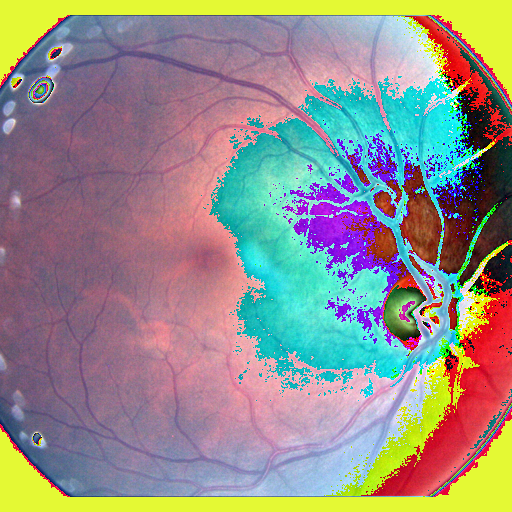

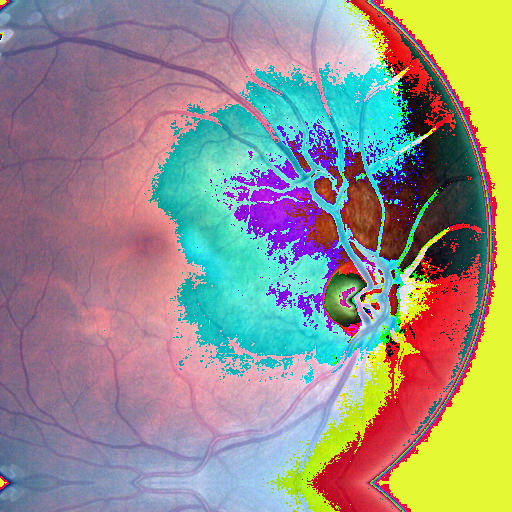

In [40]:
class Spot(object):
    def __init__(self,size,center=None, radius=None,prob = 0.5):
        self.size = size
        self.center = center
        self.radius = radius
        self.prob = prob
        self.zeros = torch.zeros((self.size, self.size)) #.cuda()
        self.ones = torch.ones((3,1)) #.cuda()
        
    def __call__(self, image, target=None):
        if random.random() < self.prob:
            #print('Spot')
            s_num =random.randint(5,10)
            mask0 = self.zeros.clone()
            center=self.center
            radius=self.radius
            for i in range(s_num):

                radius = random.randint(np.ceil(0.01*self.size),int(0.05*self.size))

                center  = [random.randint(radius+1,self.size-radius-1),random.randint(radius+1,self.size-radius-1)]
                Y, X = np.ogrid[:self.size, :self.size]
                dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)
                circle = dist_from_center <= (int(radius/2))

                k = (14/25) +(1.0-radius/25)
                beta = 0.5 + (1.5 - 0.5) * (radius/25)
                A = k * self.ones.clone()
                d =0.3 *(radius/25)
                t = np.exp(-beta * d)

                mask = self.zeros.clone()
                mask[circle] = torch.multiply(A[0], torch.tensor(1-t)) #.cuda())
                mask0 = mask0 + mask
                mask0[mask0 != 0] = 1

                sigma = (5 + (20 - 0) * (radius/25))*2
                rad_w = random.randint(int(sigma / 5), int(sigma / 4))
                rad_h = random.randint(int(sigma / 5), int(sigma / 4))
                if (rad_w % 2) == 0: rad_w = rad_w + 1
                if (rad_h % 2) == 0: rad_h = rad_h + 1

                mask = F.gaussian_blur(torch.reshape(mask,(1,self.size,self.size)), (rad_w, rad_h), sigma)
                mask = torch.stack([mask, mask, mask])
                
                image = image + torch.reshape(mask,(3,self.size,self.size))
                image = torch.clamp(image,min=0,max=1)

        return image

class Blur(object):
    def __init__(self, sigma=None, prob = 0.3):
        self.level_range = [0.1, 1]
        self.sigma = sigma
        self.prob = prob

    def __get_parameter(self):
        return np.random.uniform(self.level_range[0], self.level_range[1])

    def __call__(self, image, target=None):
        if random.random() < self.prob:
           
            rad_w = random.randint(10, 35)
            if (rad_w % 2) == 0: rad_w = rad_w + 1
            rad_h = rad_w
            print(rad_h)
            image = F.gaussian_blur(image, (rad_w,rad_h))

        return image

class Sharpness(object):
    def __init__(self, level=None, prob = 0.5):
        
        self.level_range = [0, 2]
        self.prob = prob

    def __get_parameter(self):
        return np.random.uniform(self.level_range[0], self.level_range[1])

    def __call__(self, image, target=None):
        if random.random() < self.prob:
            # print('Sharpness')
            sharpness_factor = self.__get_parameter()
            image = F.adjust_sharpness(image, sharpness_factor)
        return image
        
to_image_transform = T.ToPILImage()
post_transform = Spot(size = 512)
recrop_transfrom  = T.CenterCrop(2000)
randomcrop_transform = T.RandomCrop(2000, padding_mode='symmetric', pad_if_needed=True)
# transform = Blur()
# transform = Sharpness()
file_name = '../mnt/local/data/kalexu97/large_dataset/train/0/35062_left.jpeg'
image_init = Image.open(file_name)
image = recrop_transfrom(image_init)
image2 = randomcrop_transform(image_init)
input = torch.from_numpy(image_processor(image)['pixel_values'][0])
image = to_image_transform(input)
# print(inputs.shape)
display(image)
input = torch.from_numpy(image_processor(image2)['pixel_values'][0])
# input = post_transform(input)

image = to_image_transform(input)
# print(inputs.shape)
display(image)


# image = transform(image)
# display(image)


Predicted class: 0


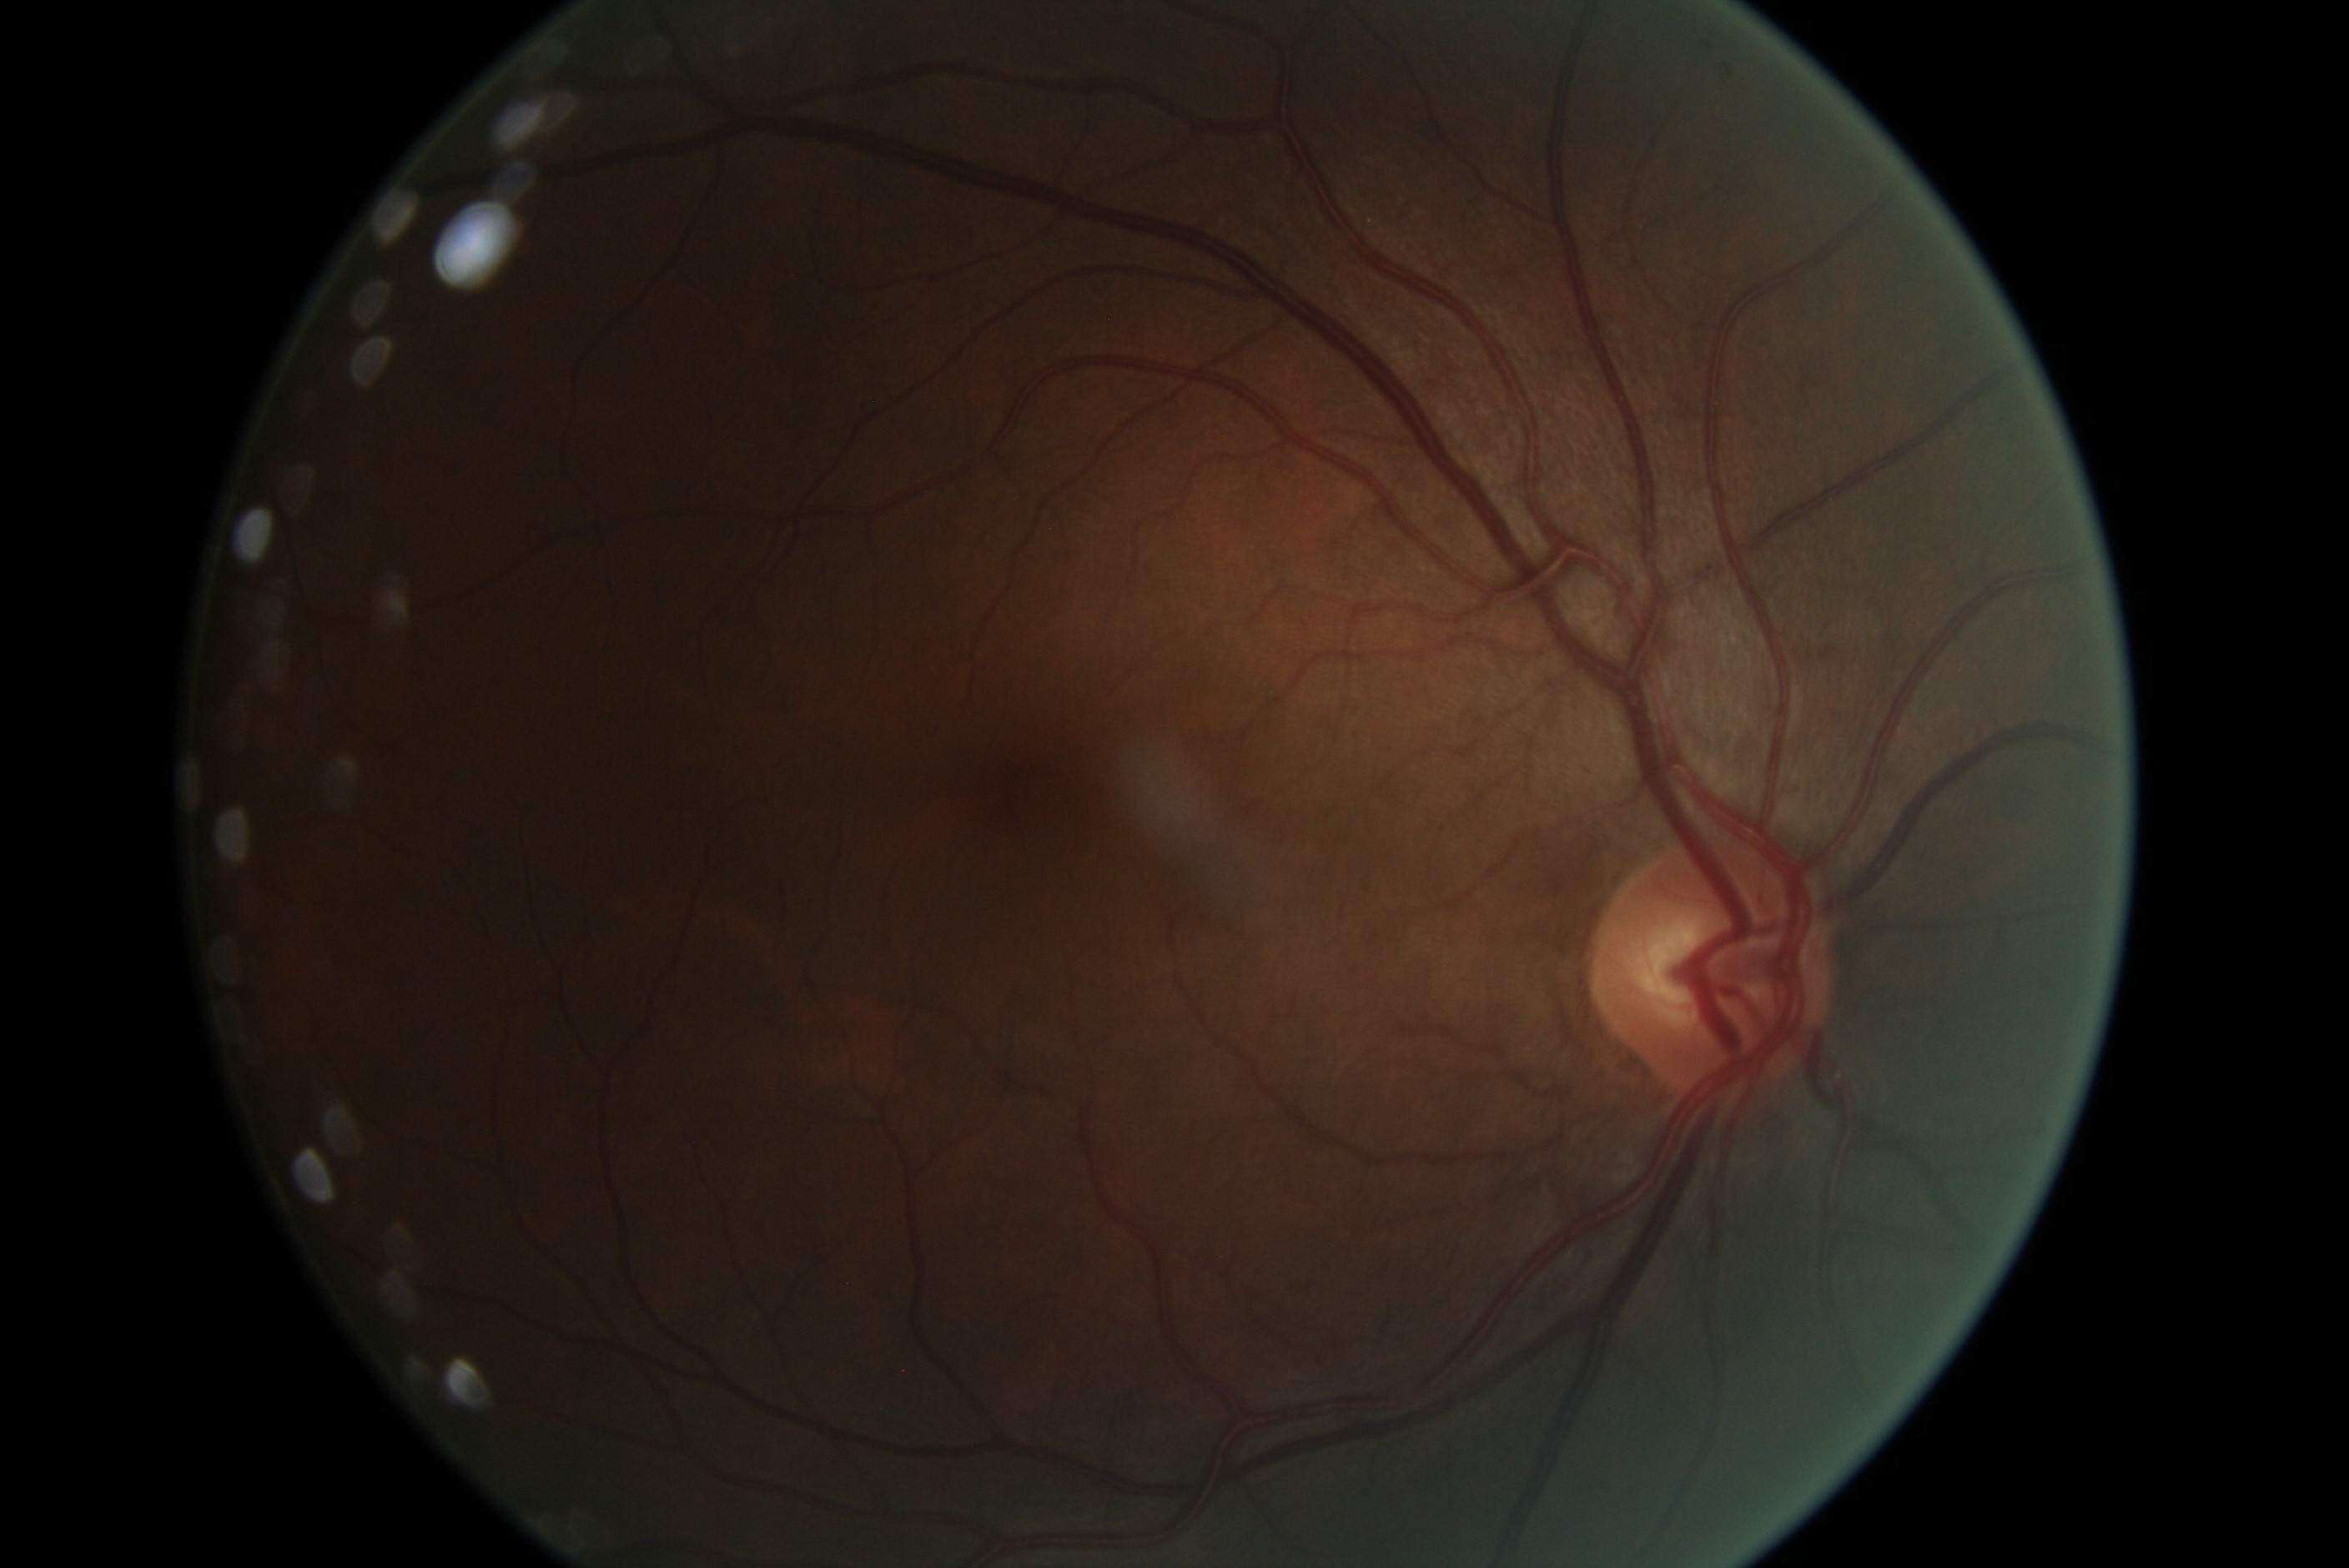

In [2]:
from transformers import AutoFeatureExtractor, SwinForImageClassification
from PIL import Image

file_name = '../mnt/local/data/kalexu97/large_dataset/train/0/35062_left.jpeg'
image = Image.open(file_name)

feature_extractor = AutoFeatureExtractor.from_pretrained("./saved_models/swin384_originpreprocessor_rt15")
model = SwinForImageClassification.from_pretrained("./saved_models/swin384_originpreprocessor_rt15")

inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits
# model predicts one of the 1000 ImageNet classes
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])
display(image)

In [17]:
from transformers import AutoFeatureExtractor
from transformers import ViTImageProcessor

# feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/swin-base-patch4-window12-384")
feature_extractor = ViTImageProcessor.from_pretrained("microsoft/swin-base-patch4-window12-384")